# Test 3 on kepler and TESS data 

In [66]:
import pandas as pd
import sys
import os

# Added paths to import modules
sys.path.insert(0, os.path.abspath('../'))

# import custom modules
from data_processing.distribution import (plot_class_distribution, plot_feature_importances,
                                          plot_hist_feature_distributions,
                                          plot_hist_feature_distributions_0_1,
                                          compute_train_0_1)
from data_processing.data_analysis import (compute_all_columns_nan, print_nan_numbers_for_features,
                                           threshold_delete_nan)
from data_processing.data_scaling import plot_top_7_difference, data_scaling_normalization
from data_processing.features_prosessing import (remove_non_numeric_columns, rows_id_nan,
                                                 remove_nan_label, feature_processing_kepler_tess)
from data_processing.knn_imputer import k_nearest_neighbors_imputer
from data_processing.replace_disposition import replace_label
from dimensionality_reduction.features_selection import compute_feature_importance, feature_selection_rfc
from model_selection.grid_search import grid_search_param_optimization
from utils.mission import Mission
from utils.util import print_count_nan, print_feature_importance

# Read Data

read the csv file taken from:
1. Kepler: NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
2. TESS: ExoFOP https://exofop.ipac.caltech.edu/tess/view_toi.php

In [67]:
kepler_data = pd.read_csv('../data/raw_data/cumulative_2023.11.04_08.48.13.csv')
tess_data = pd.read_csv('../data/raw_data/tess_exofop.csv')
print('Shape of Kepler Cumulative KOI', kepler_data.shape)
print('Shape of ExoFOP TESS data:', tess_data.shape)
_ = print_count_nan(data=kepler_data, name='Kepler Cumulative KOI')
_ = print_count_nan(data=tess_data, name='TESS')

Shape of Kepler Cumulative KOI (9564, 141)
Shape of ExoFOP TESS data: (6977, 62)
Number of NaN values in Kepler Cumulative KOI: 237116 out of 1348524: 17.58%
Number of NaN values in TESS: 38201 out of 432574: 8.83%


# Replace Label

In the data initially there is an disposition that includes 3 or more classes.

Kepler:
1. CONFIRMED
2. CANDIDATE
3. FALSE POSITIVE

with the aim of making a binary classifier we use the following procedure to replace:
1. CONFIRMED, CANDIDATE with the label: 1
2. FALSE POSITIVE with the label: 0

TESS: Disposizione TFOPWG
1. APC = Candidato Planetario Ambiguo
2. CP = Pianeta Confermato
3. FA = Falso Allarme
4. FP = Falso Positivo
5. KP = Pianeta Conosciuto
6. PC = Candidato Planetario

with the aim of making a binary classifier we use the following procedure to replace:
1. KP, CP, PC with the label: 1
2. APC, FA, FP with the label: 0

NASA Exoplanet Archive documentation: https://exoplanetarchive.ipac.caltech.edu/docs/API_TOI_columns.html 

ExoFOP documentation: https://exofop.ipac.caltech.edu/tess/tsm.php

In [68]:
kepler_data = replace_label(data=kepler_data, mission=Mission.KEPLER)
tess_data = replace_label(data=tess_data, mission=Mission.TESS)
print('Shape of kepler data: ', kepler_data.shape)
print('Shape of TESS data: ', tess_data.shape)

Shape of kepler data:  (9564, 141)
Shape of TESS data:  (6977, 62)


# Feature and Label Processing

The Kepler and TESS data have different features, so we want to find an intersection between the two sets of data. To do this, we perform several operations:

1. Removing non-numeric features
2. Removing of identifying and follow-up characteristics
3. Identifying the labels (X_train, y_train)
4. Removing NaN in y_train and correspondingly also the X_train rows (if there are)

In [69]:
X_train, y_train = feature_processing_kepler_tess(kepler_data=kepler_data, tess_data=tess_data)


After the processing:
Number of NaN values in TESS   : 22338 out of 181402: 12.31%
Number of NaN values in Kepler : 7219 out of 229536: 3.15%


In [70]:
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)
_ = print_count_nan(data=y_train, name='y_train')

Shape of X_train data:  (16541, 26)
Shape of y_train data:  (16541,)
Number of NaN values in y_train: 98 out of 16541: 0.59%


In [71]:
# Removing NaN in y_train and correspondingly also the X_train rows
X_train, y_train = remove_nan_label(X_train, y_train)
count = y_train.isna().sum()
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)
_ = print_count_nan(data=X_train, name='X_train')
_ = print_count_nan(data=y_train, name='y_train')

Shape of X_train data:  (16443, 26)
Shape of y_train data:  (16443,)
Number of NaN values in X_train: 48359 out of 427518: 11.31%
Number of NaN values in y_train: 0 out of 16443: 0.00%


In [72]:
# Delete columns
name_columns_to_delete = ['RA', 'Dec', 'Epoch (BJD)', 'Epoch (BJD) err']
X_train = X_train.drop(columns=name_columns_to_delete)

# Data Scaling

Nonostante non costituisca un prerequisito necessario nei modelli di machine learning, il processo di normalizzare i dati è tipicamente impiegato con l'obiettivo di:

1. Standardizzare l'intervallo di valori di tutte le caratteristiche del dataset
2. Migliorare la robustezza numerica degli algoritmi impiegati.

Plot Before the scaling


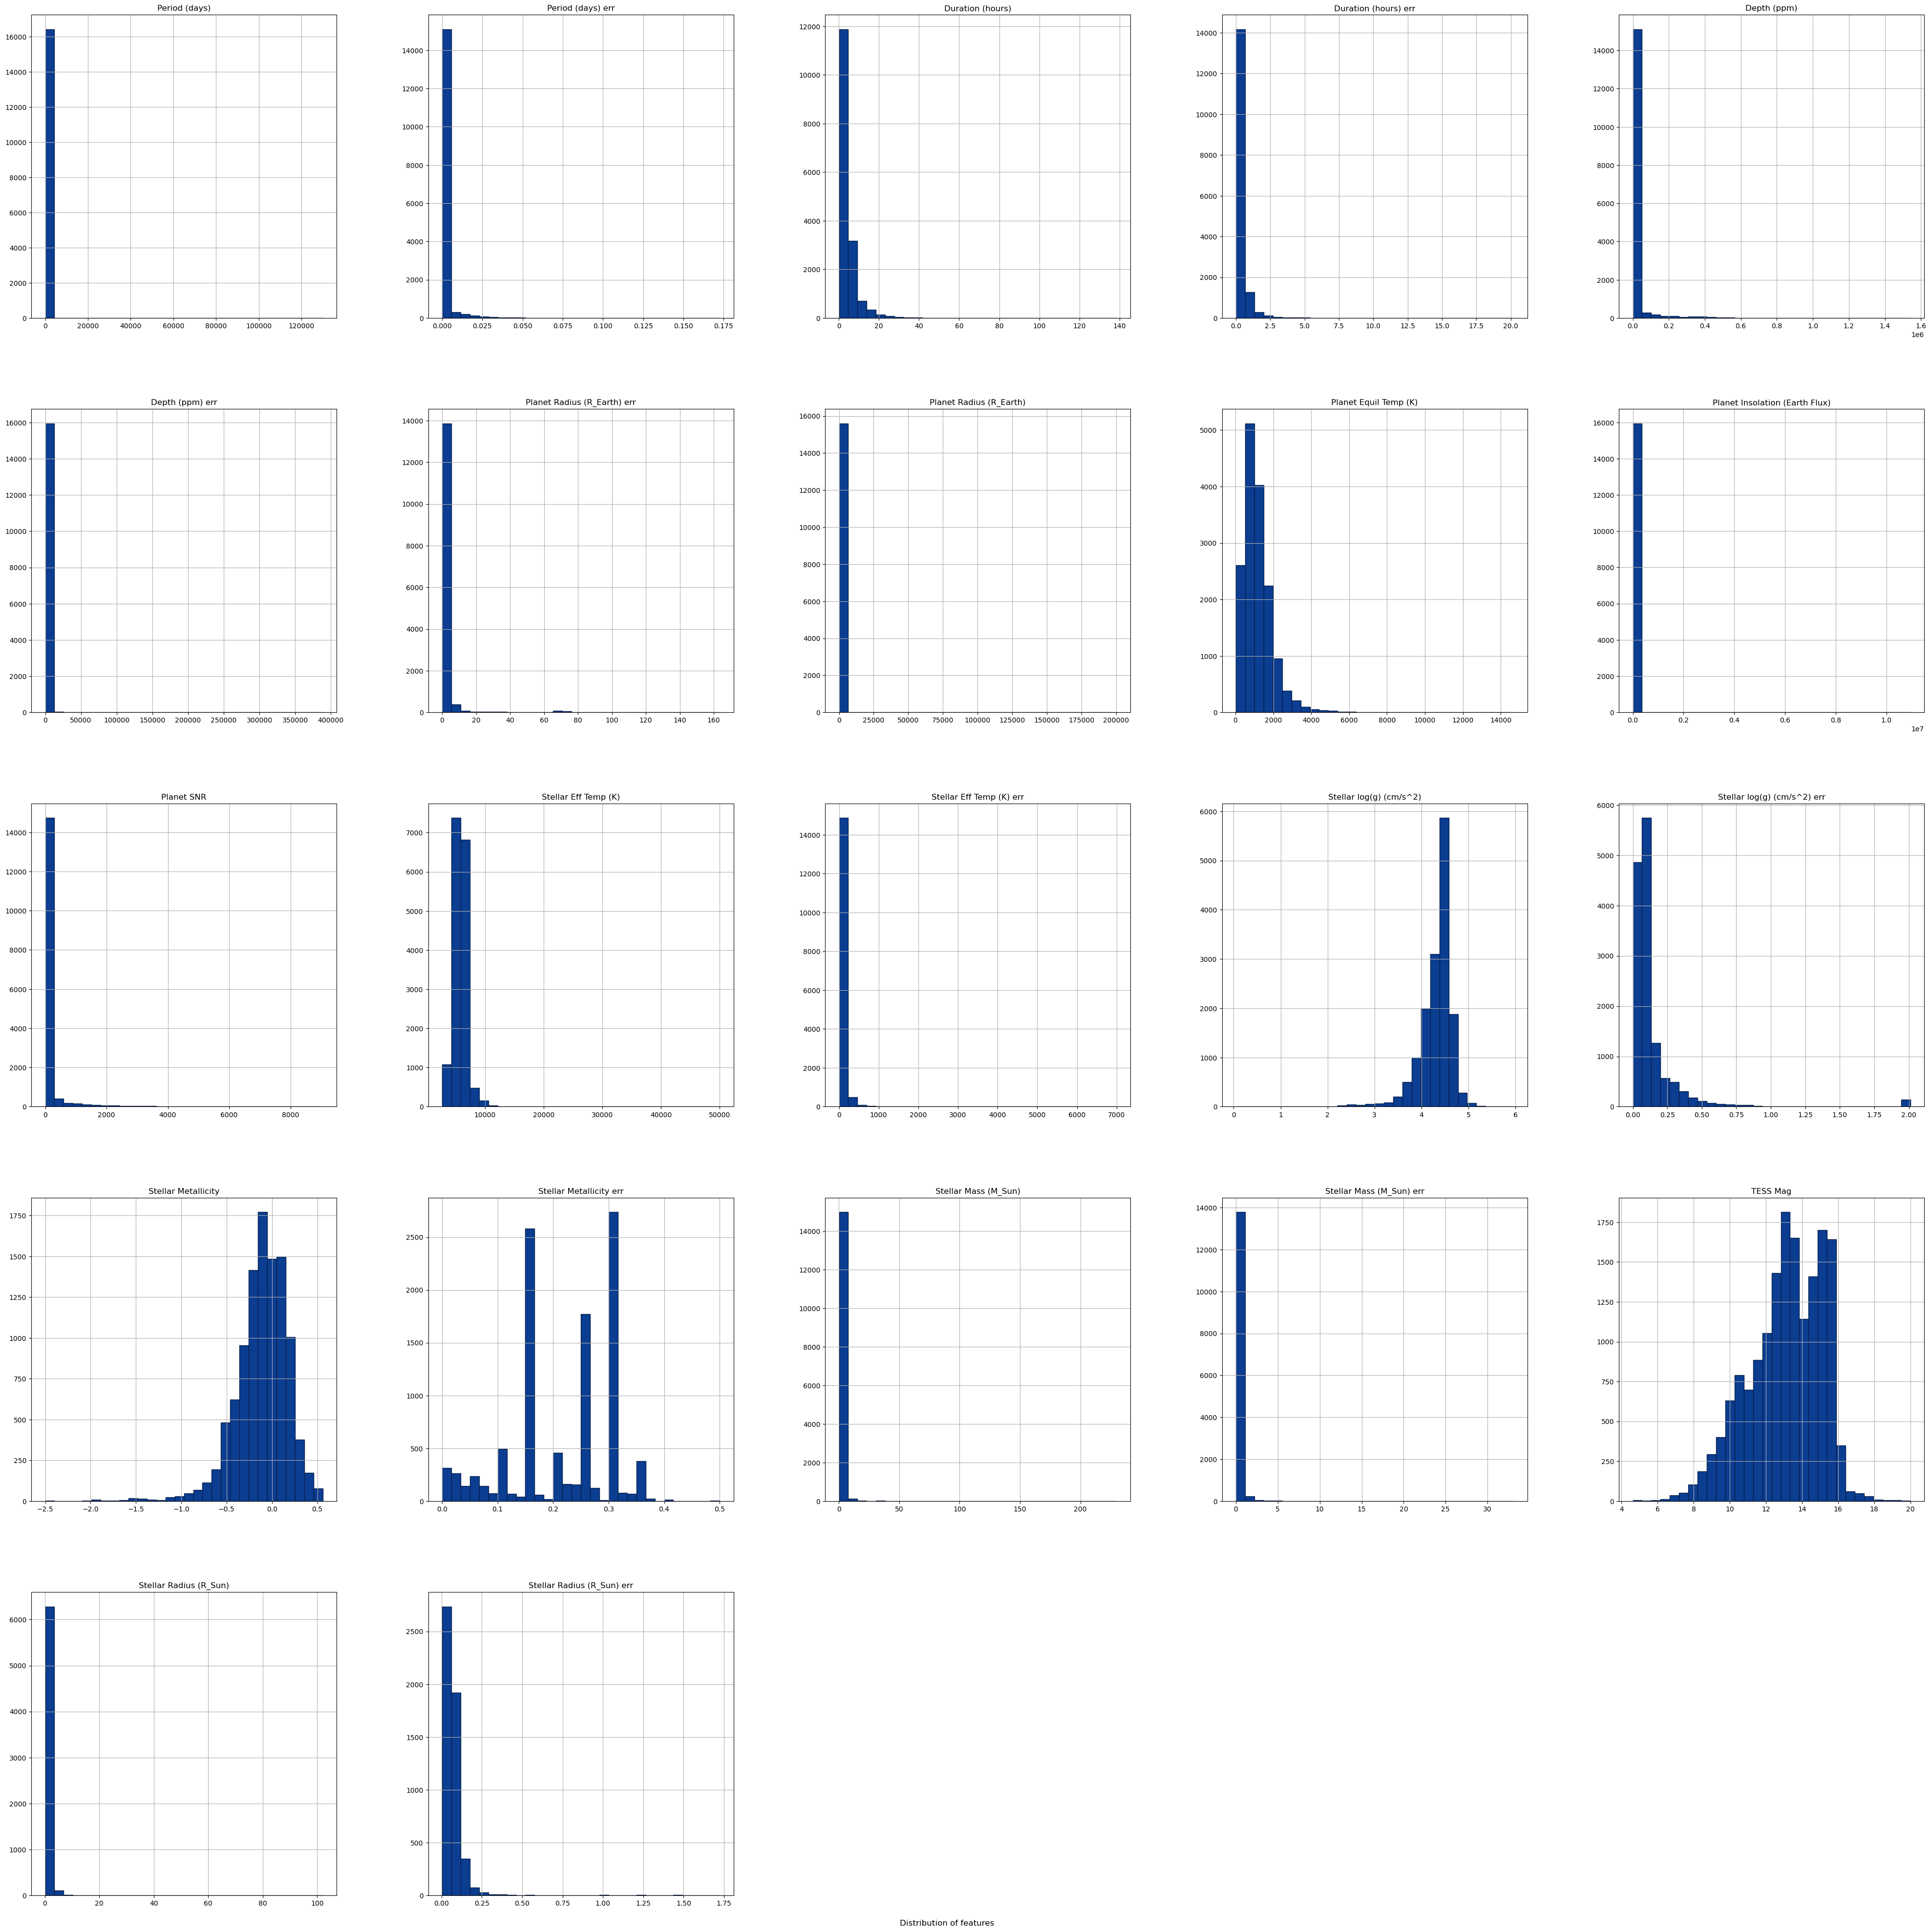

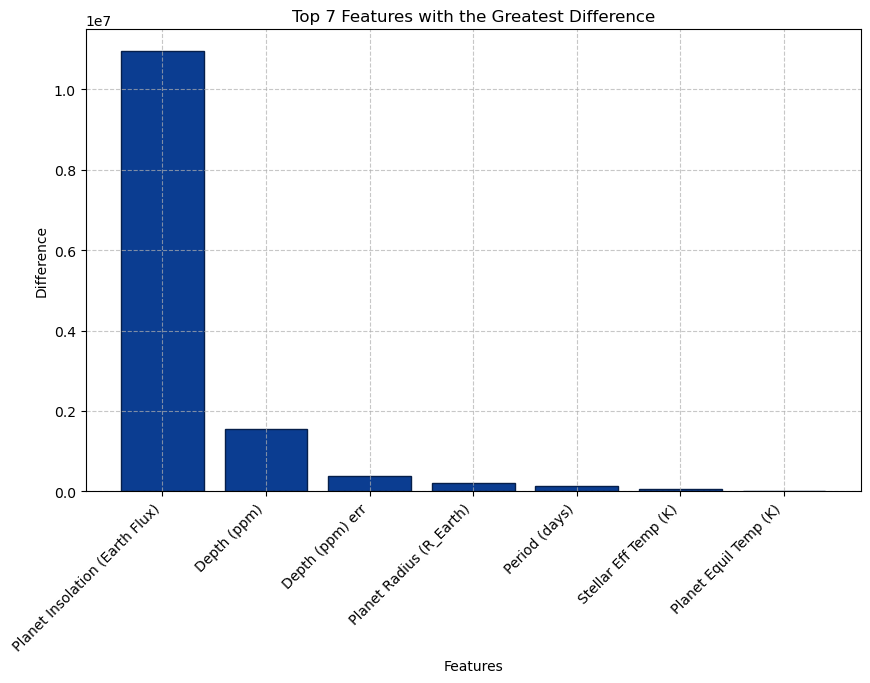

In [8]:
print('Plot Before the scaling')
plot_hist_feature_distributions(X_train=X_train)
plot_top_7_difference(X_train=X_train)

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_normalized, columns=X_train.columns)

# K-Nearest Neighbors

The NaN problem must be managed carefully, there are several solutions that can be used, one of these is the KNN methodology which calculates a distance (e.g. Euclidean or Manhattan) between the observations and calculates the new value to be inserted with some methodologies (e.g. IDWM or IRWM) but considering the nearest K, where K is defined a priori, generally for K the square root of N is considered where N is the number of observations, or an approximation is used.

In this case, for efficiency reasons, the sklearn KNNImputer module was used which is optimized.

In [73]:
_ = print_count_nan(data=X_train, name='X_train')
print('Shape of X_train:', X_train.shape)

Number of NaN values in X_train: 47905 out of 361746: 13.24%
Shape of X_train: (16443, 22)


In [74]:
# Calculate columns that contain only nan and the number of nan for each columns
nan_columns = compute_all_columns_nan(data=X_train)
number_of_nan_columns = {col: X_train[col].isna().sum() for col in X_train}
number_of_nan_columns = dict(sorted(number_of_nan_columns.items(), key=lambda x: x[1], reverse=True))
print_nan_numbers_for_features(data=X_train, number_of_nan_columns=number_of_nan_columns)

Columns containing only not a number in X_train: []
Number of Observations: 16443
NaN for each feature
  1: Stellar Radius (R_Sun) err----> 11281
  2: Stellar Radius (R_Sun)--------> 10031
  3: Stellar Metallicity err-------> 6048
  4: Stellar Metallicity-----------> 6047
  5: Stellar log(g) (cm/s^2) err---> 2469
  6: Stellar Mass (M_Sun) err------> 2342
  7: Planet Radius (R_Earth) err---> 1819
  8: Stellar Mass (M_Sun)----------> 1278
  9: Stellar log(g) (cm/s^2)-------> 1152
 10: Stellar Eff Temp (K) err------> 889
 11: Planet Radius (R_Earth)-------> 830
 12: Planet Equil Temp (K)---------> 642
 13: Stellar Eff Temp (K)----------> 493
 14: Planet Insolation (Earth Flux)> 476
 15: Duration (hours) err----------> 467
 16: Depth (ppm) err---------------> 460
 17: Period (days) err-------------> 454
 18: Depth (ppm)-------------------> 363
 19: Planet SNR--------------------> 363
 20: TESS Mag----------------------> 1
 21: Period (days)-----------------> 0
 22: Duration (hours)--------

In [75]:
TCOL = 2400
nan_columns = threshold_delete_nan(number_of_nan_columns=number_of_nan_columns,
                                        nan_columns_name=nan_columns, threshold=TCOL)
X_train = X_train.drop(columns=nan_columns)
print_count_nan(data=X_train, name='X_train')
print('Shape of X_train:', X_train.shape)

Number of NaN values in X_train: 12029 out of 279531: 4.30%
Shape of X_train: (16443, 17)


In [80]:
# Compute the number of not a number for each rows
number_of_nan_rows = X_train.isna().sum(axis=1)
TROW = 0.5
id_rows = rows_id_nan(number_of_nan_rows=number_of_nan_rows,
                      X_train=X_train, threshold=TROW)

Total rows >= of T=0.5: 1184 out of a total of 13798 By eliminating them you obtain 12614 observations


In [81]:
# Drop rows >= T
X_train = X_train.drop(id_rows).reset_index(drop=True)
y_train = y_train.drop(id_rows).reset_index(drop=True)

In [82]:
print('Shape of X_train:', X_train.shape)
_ = print_count_nan(data=X_train, name='X_train')

Shape of X_train: (12614, 17)
Number of NaN values in X_train: 0 out of 214438: 0.00%


In [83]:
INDEX_OF_K = 10
# Using KNNImputer
X_train = k_nearest_neighbors_imputer(X_train=X_train, index_of_k=INDEX_OF_K)
count = X_train.isna().sum()
print('Number of not a number in X_train is:', count.sum())
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)

Number of NaN values in X_train: 0 out of 214438: 0.00%
There are no NaN
Number of not a number in X_train is: 0
Shape of X_train data:  (12614, 17)
Shape of y_train data:  (12614,)


In [84]:
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)

Shape of X_train data:  (12614, 17)
Shape of y_train data:  (12614,)


Plot After the scaling and KNNImputer


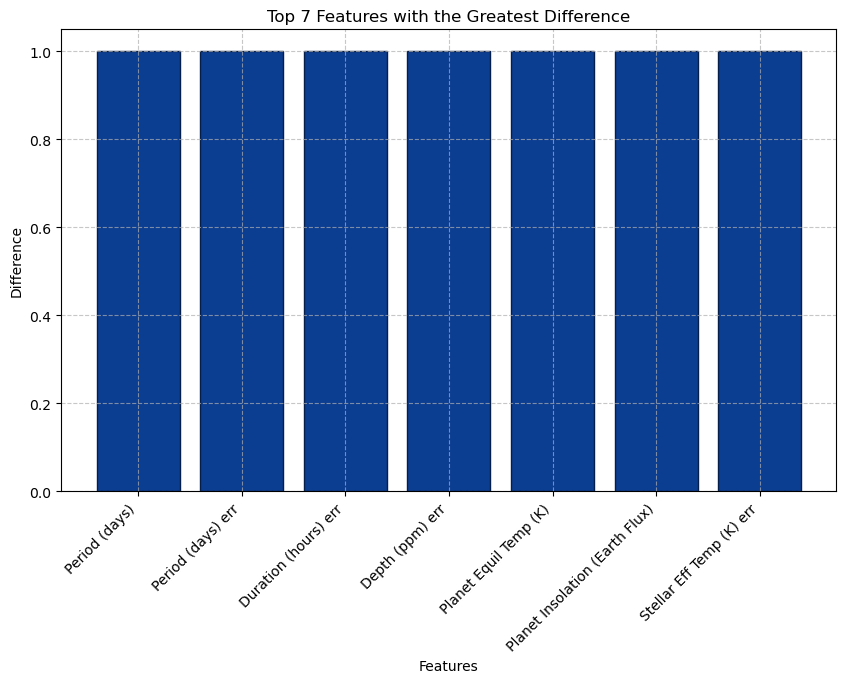

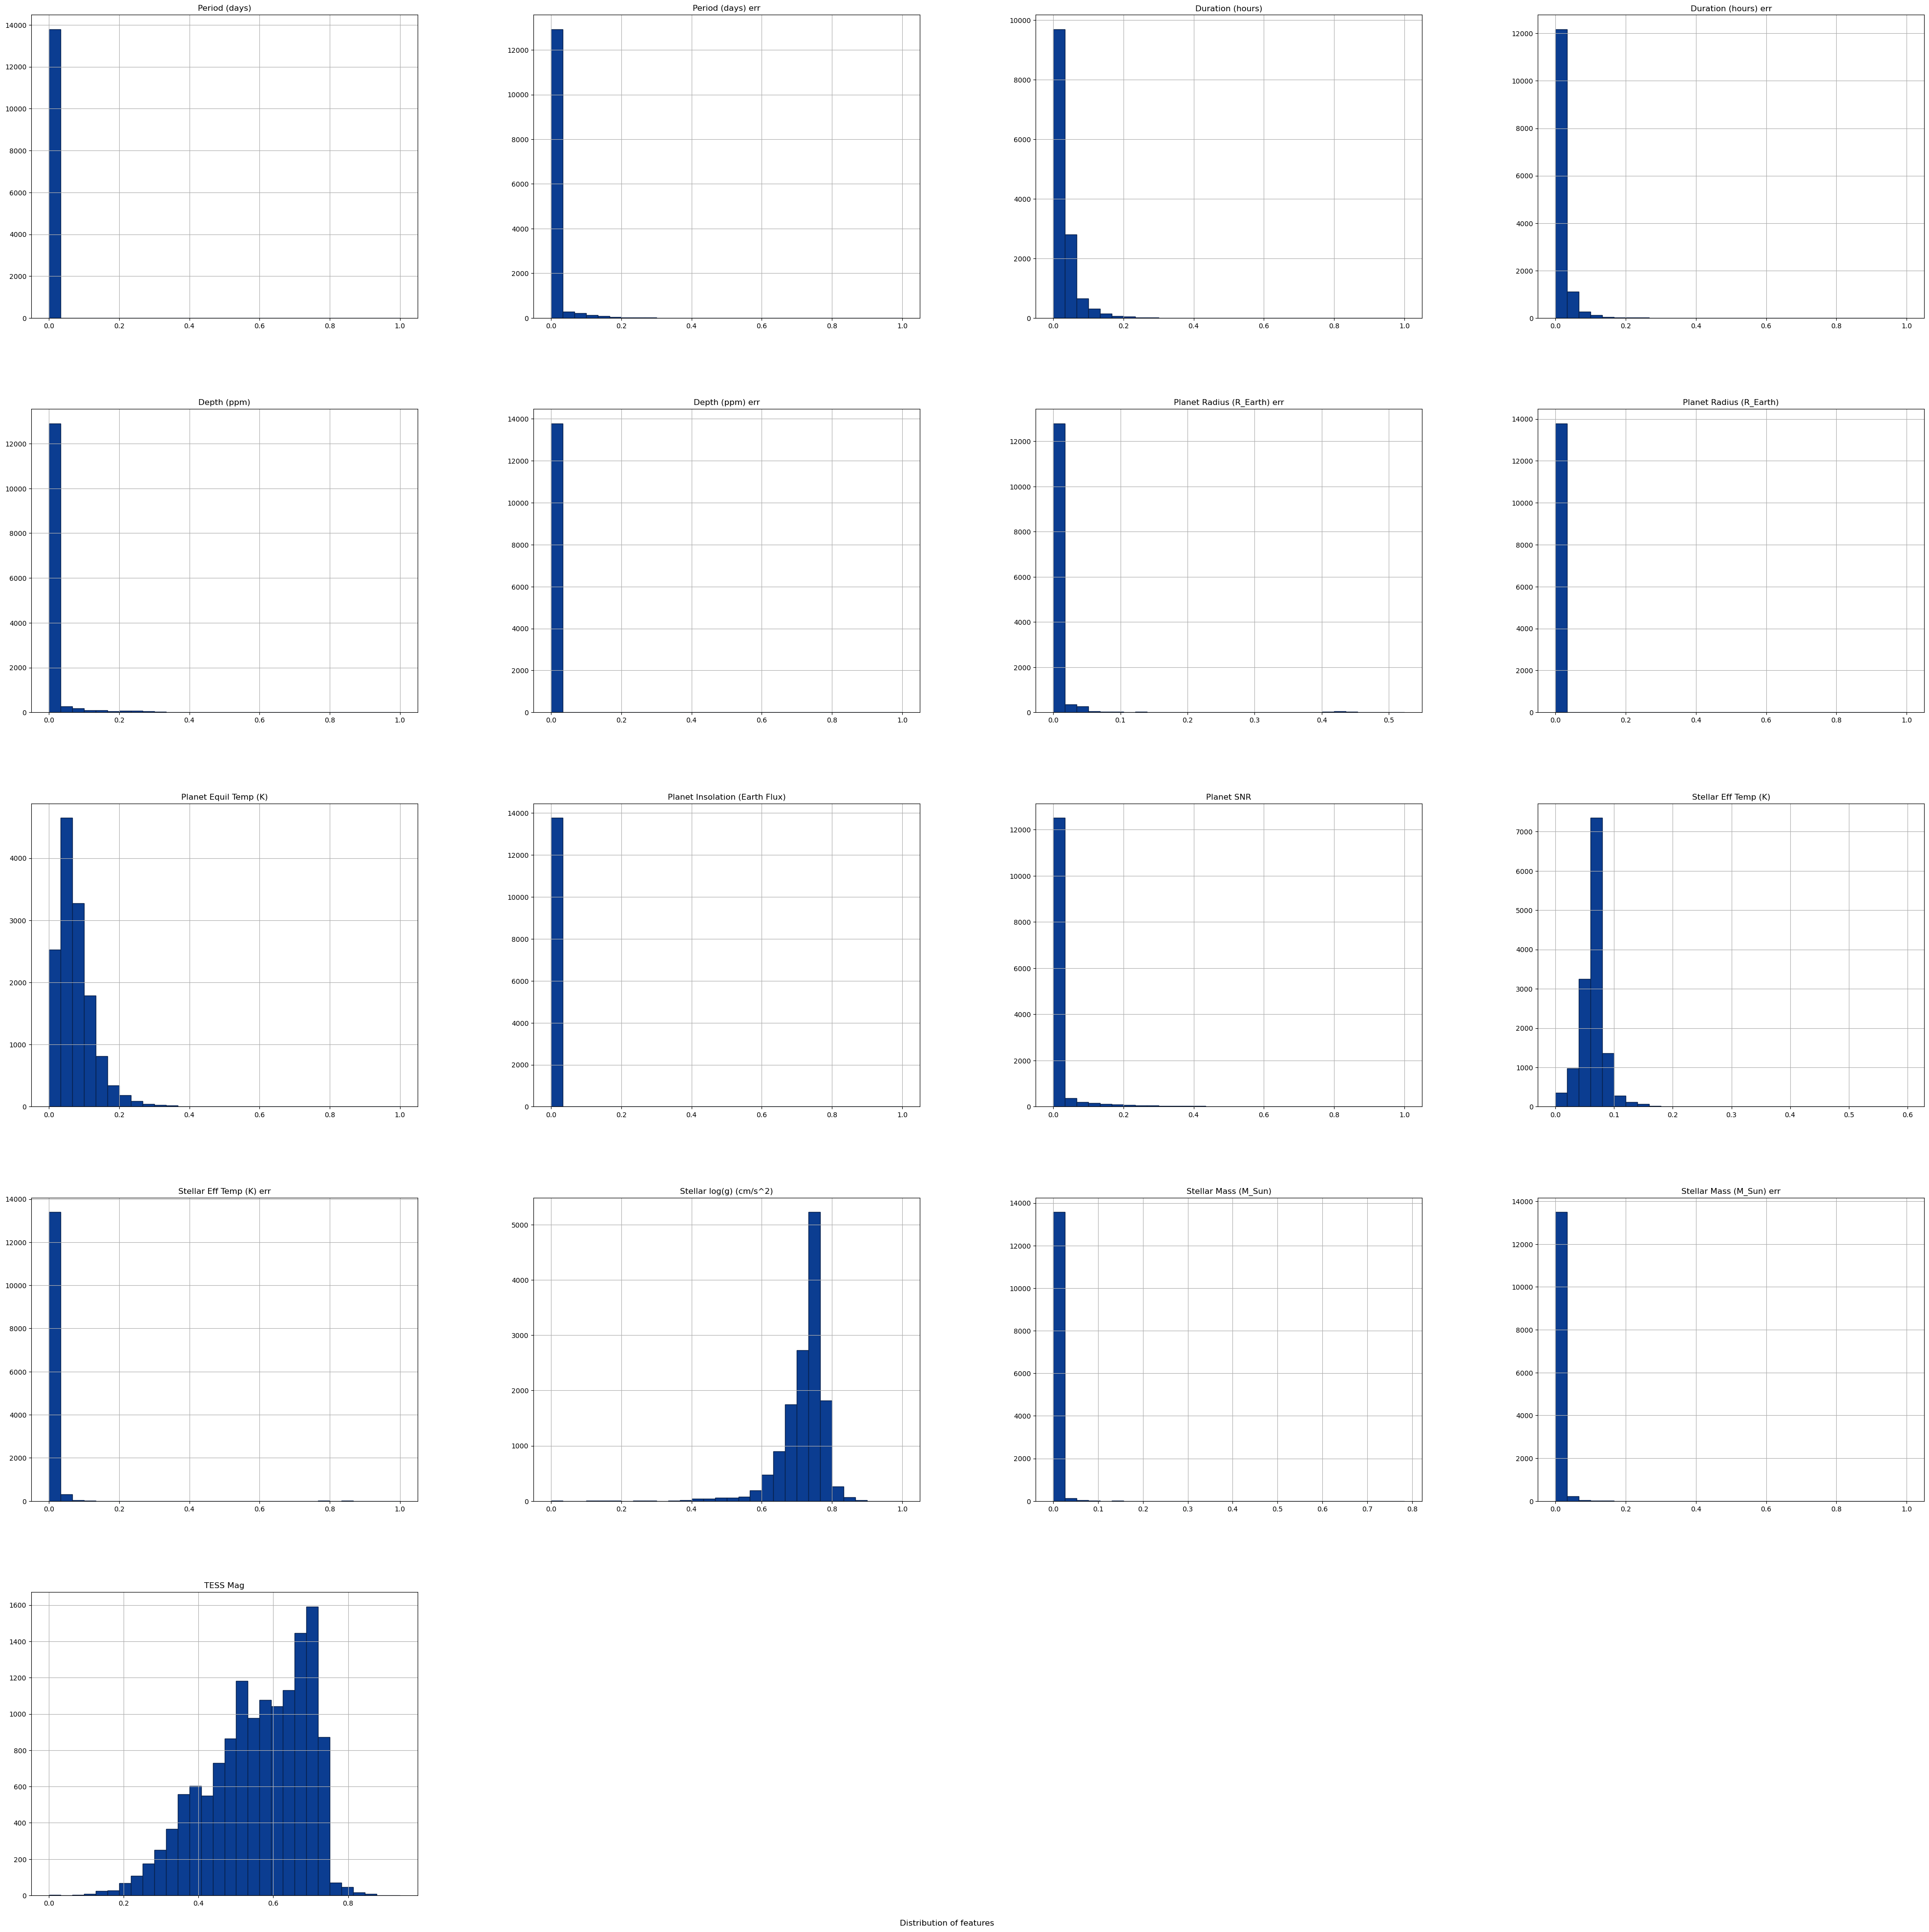

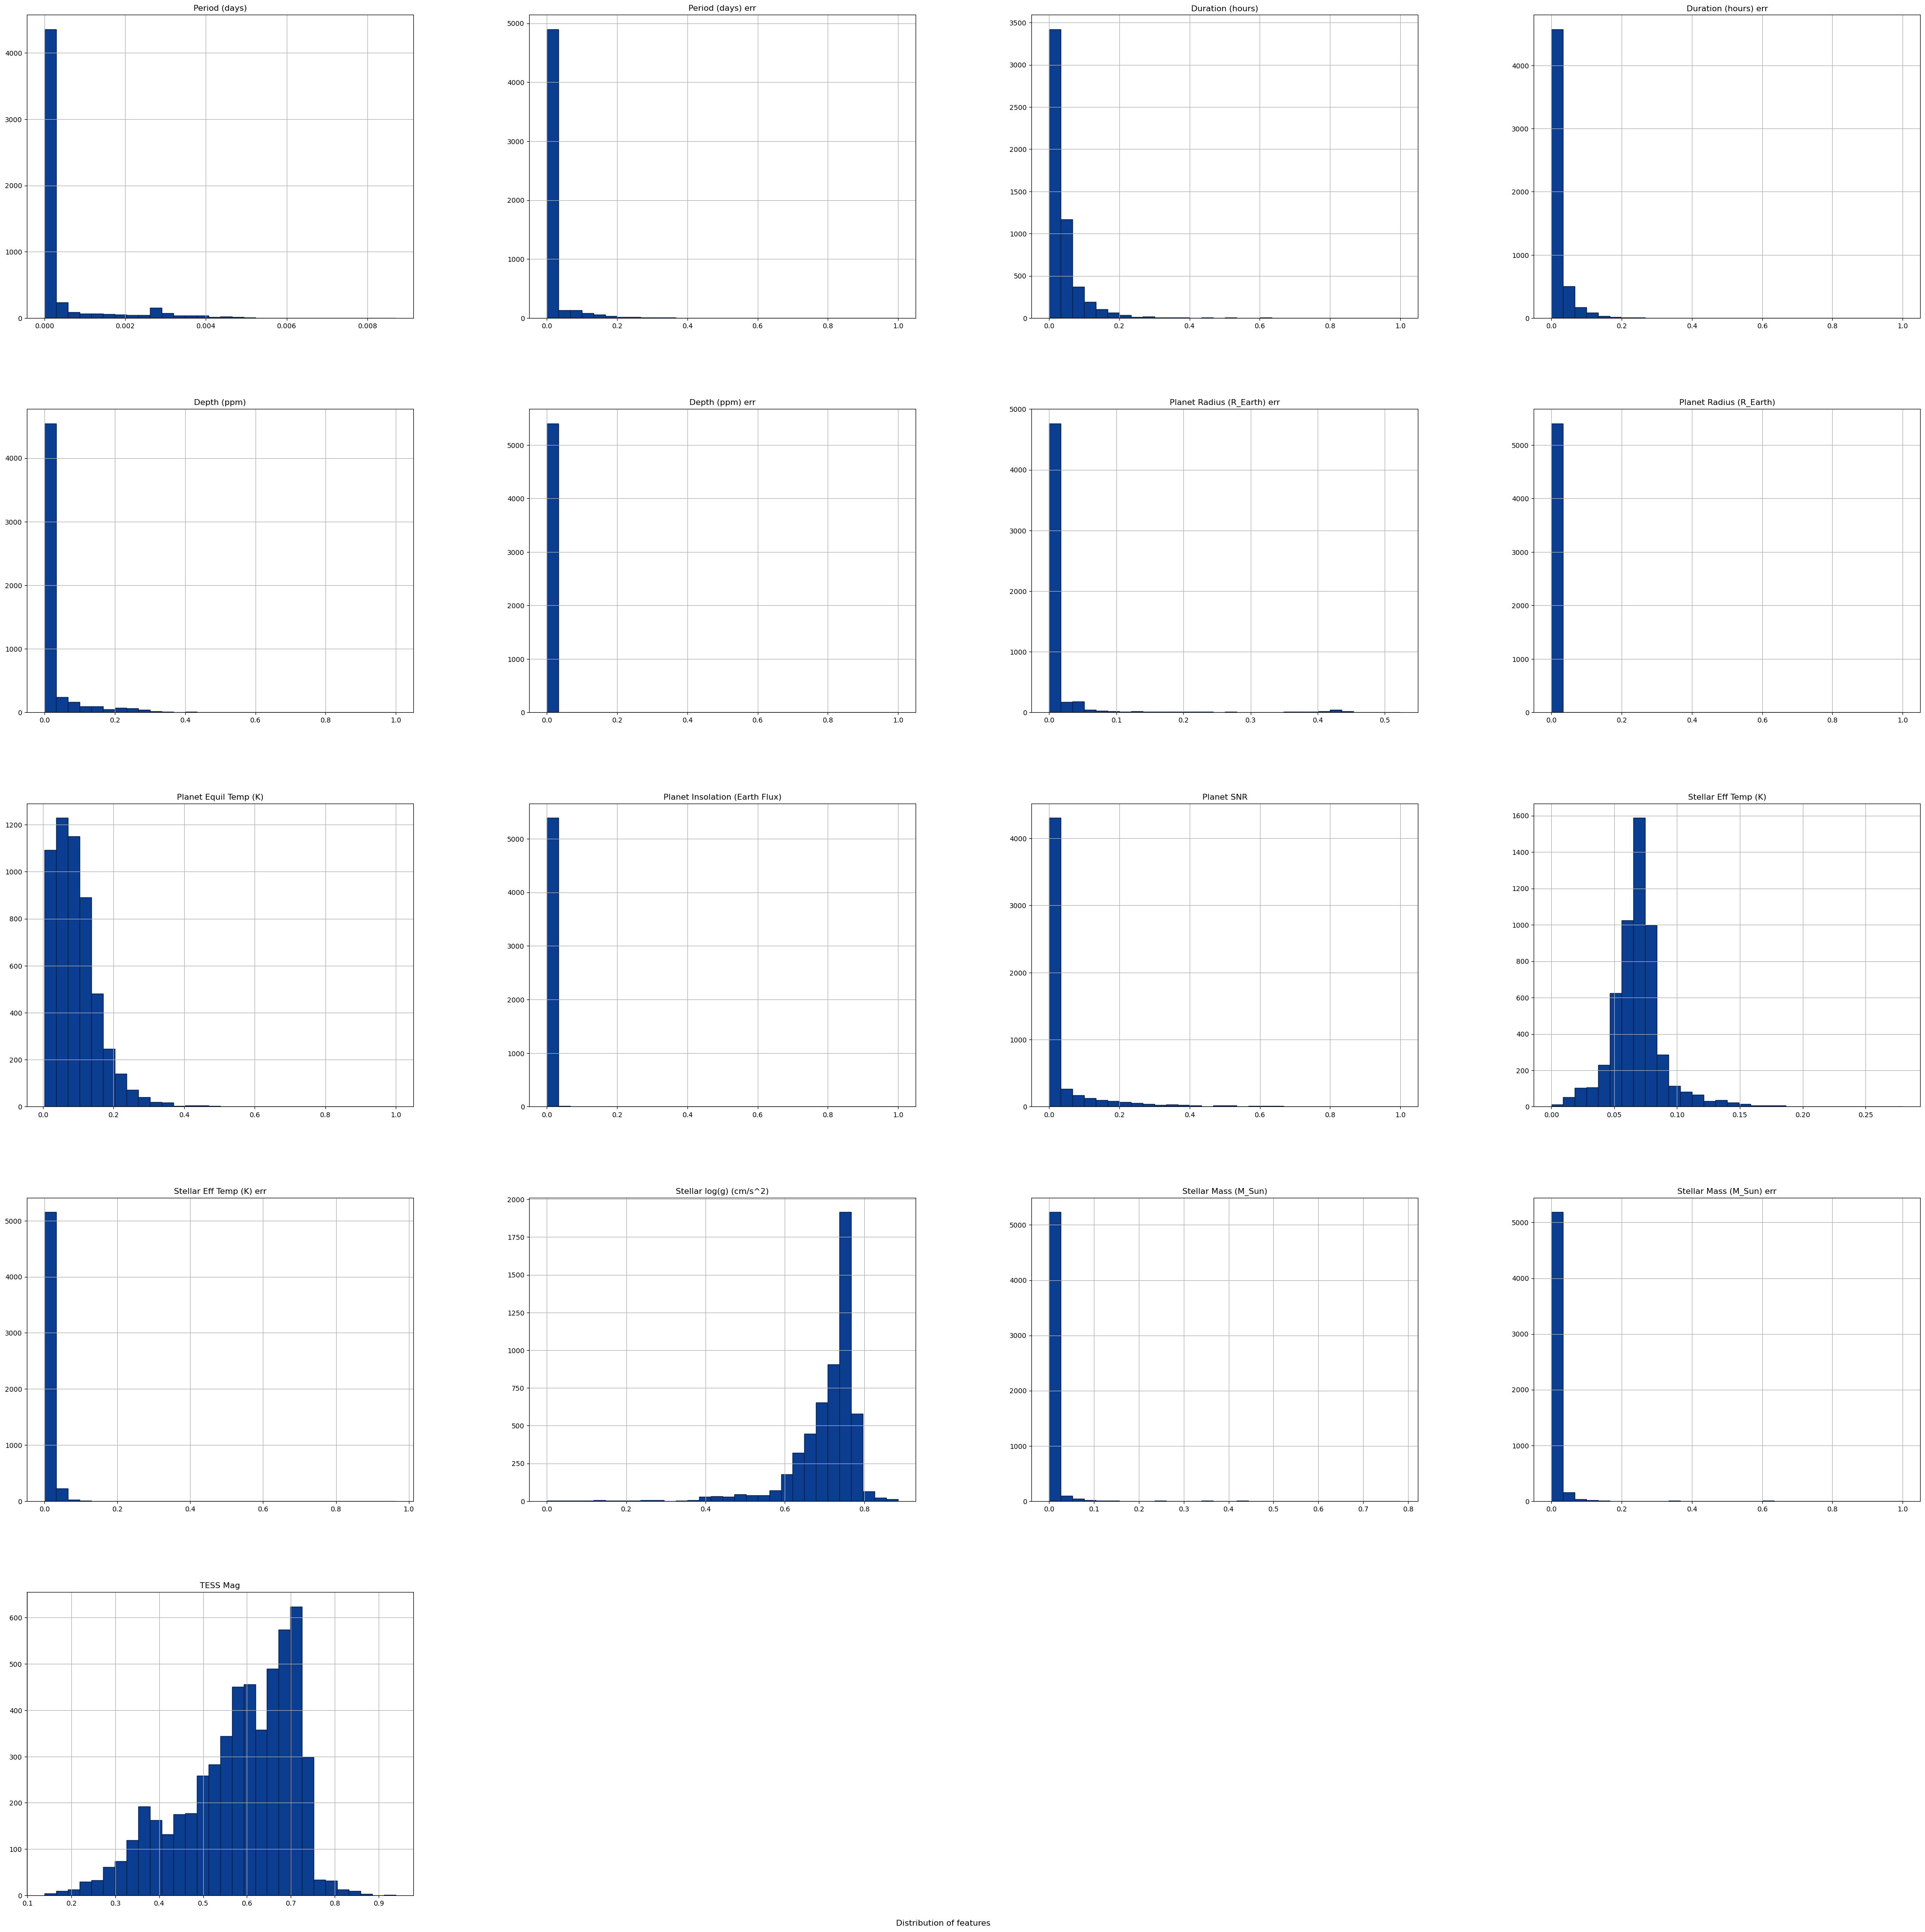

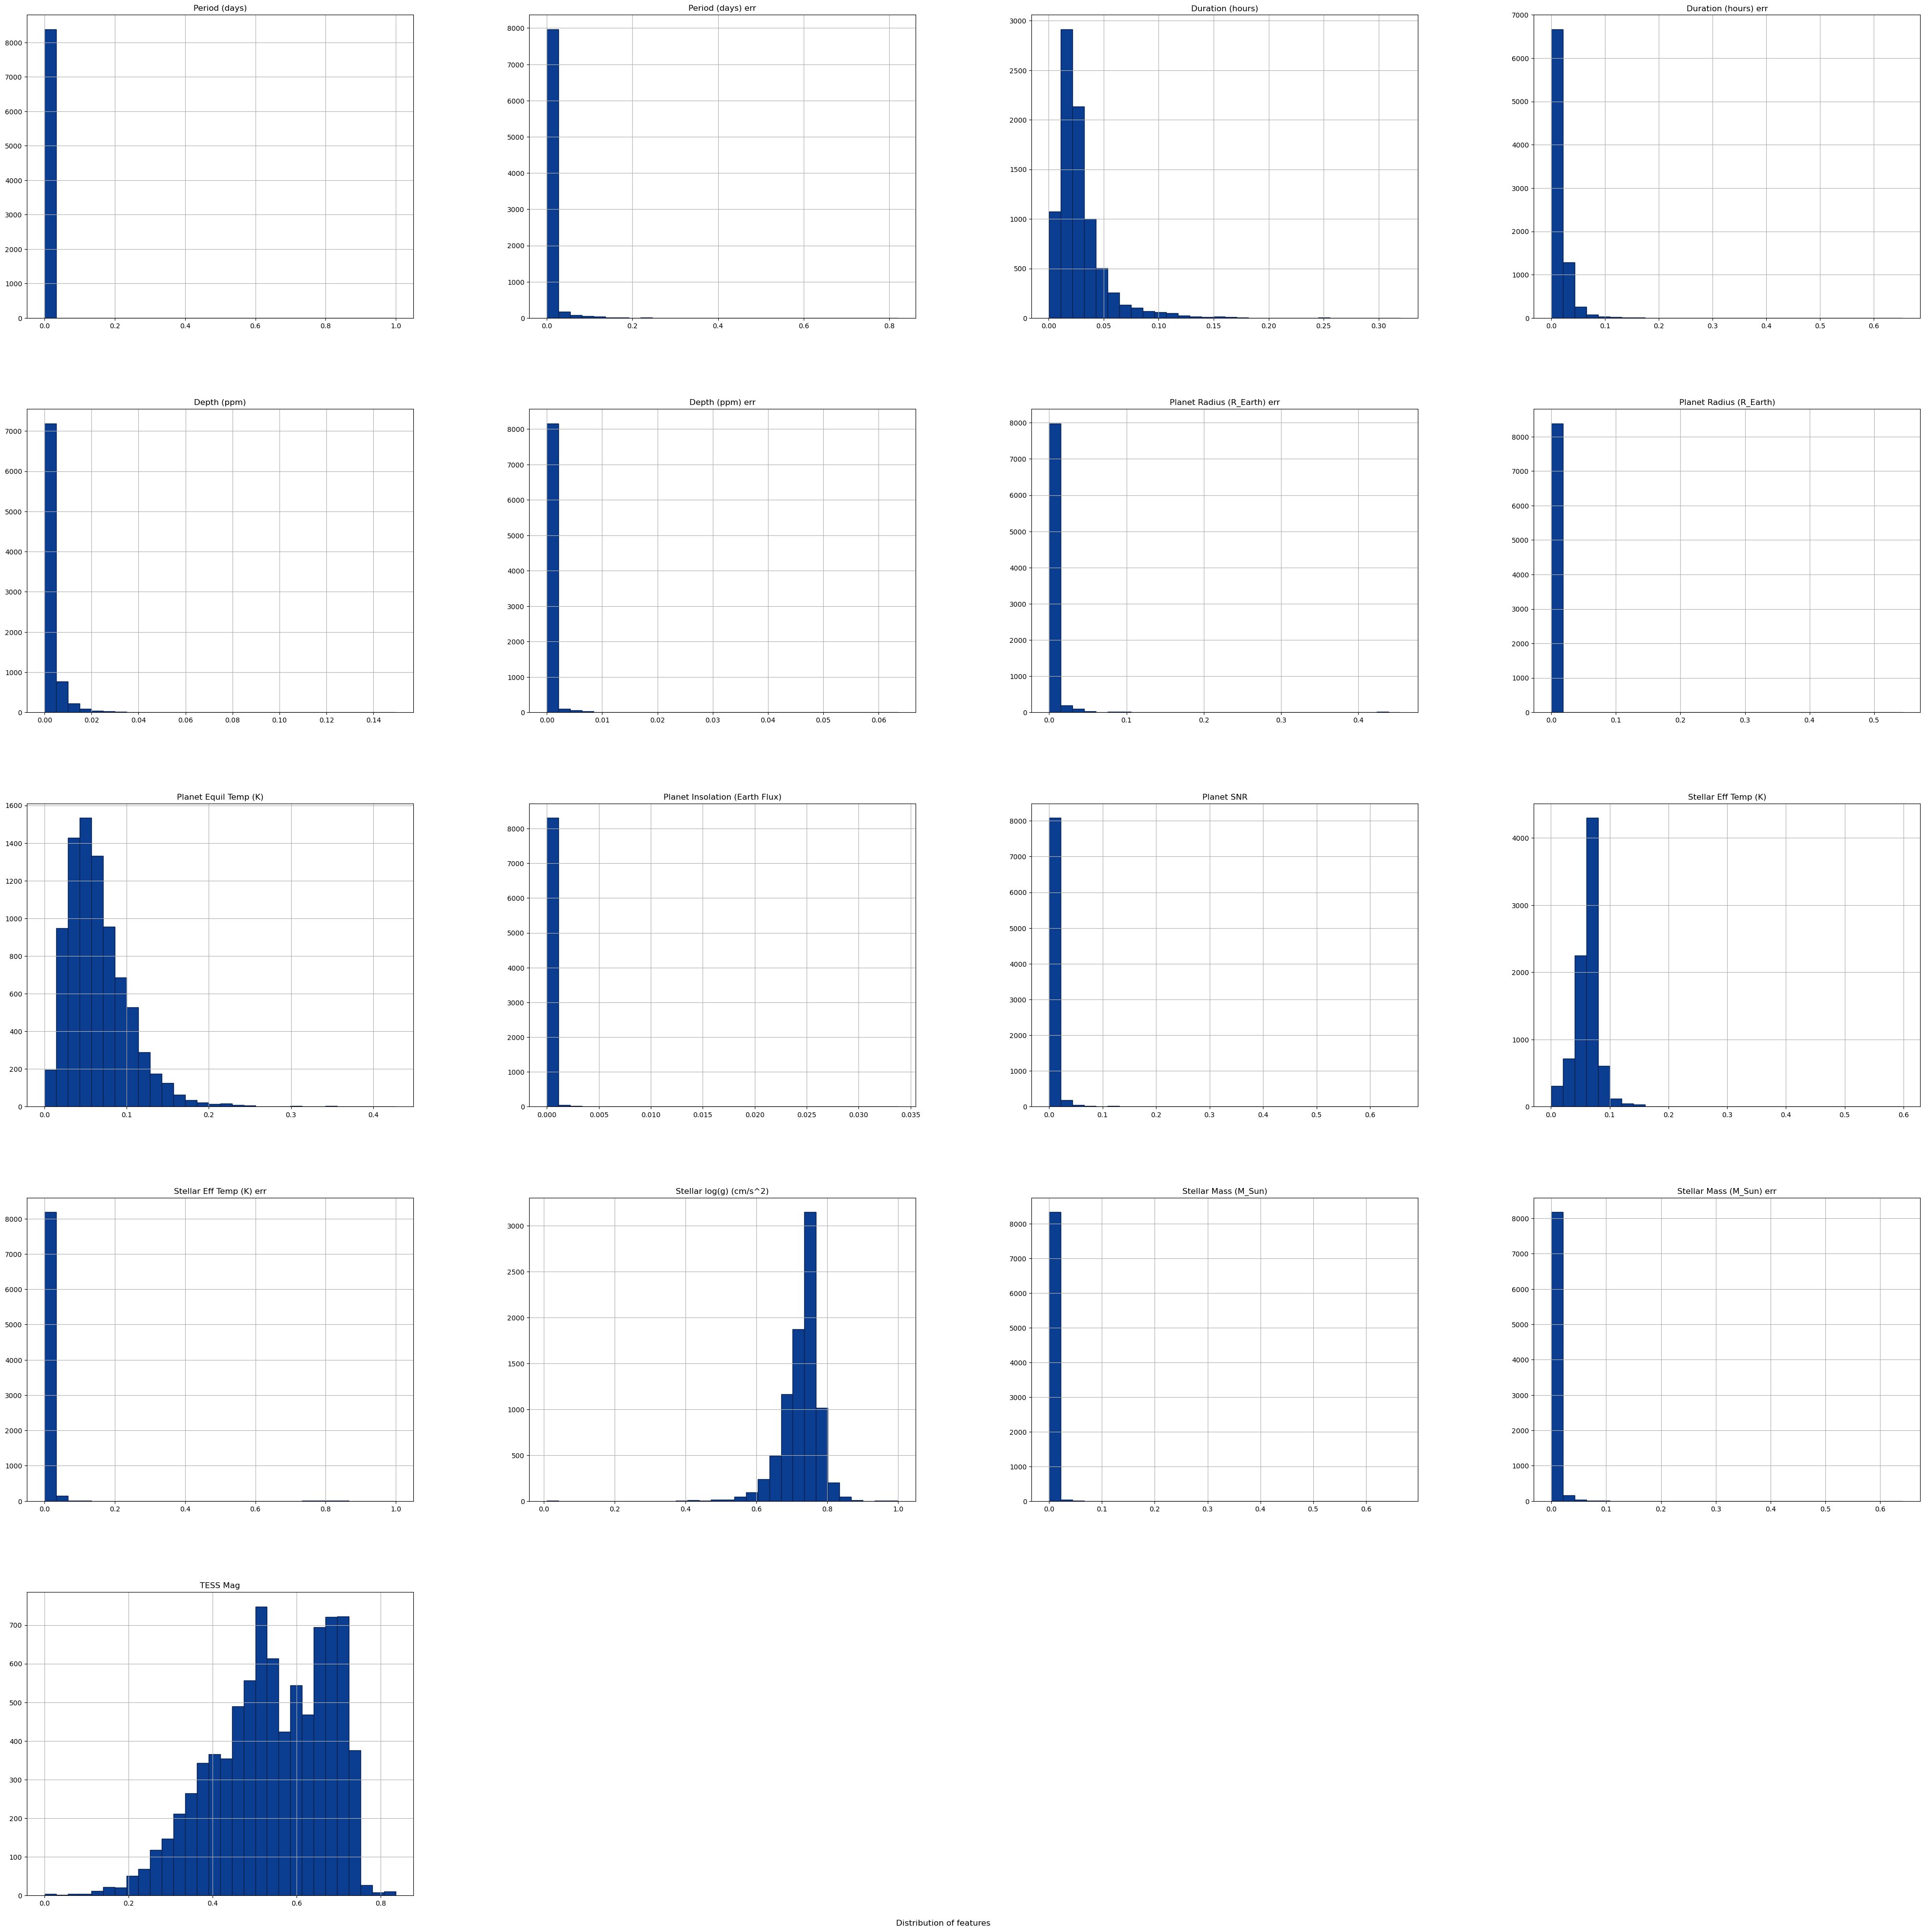

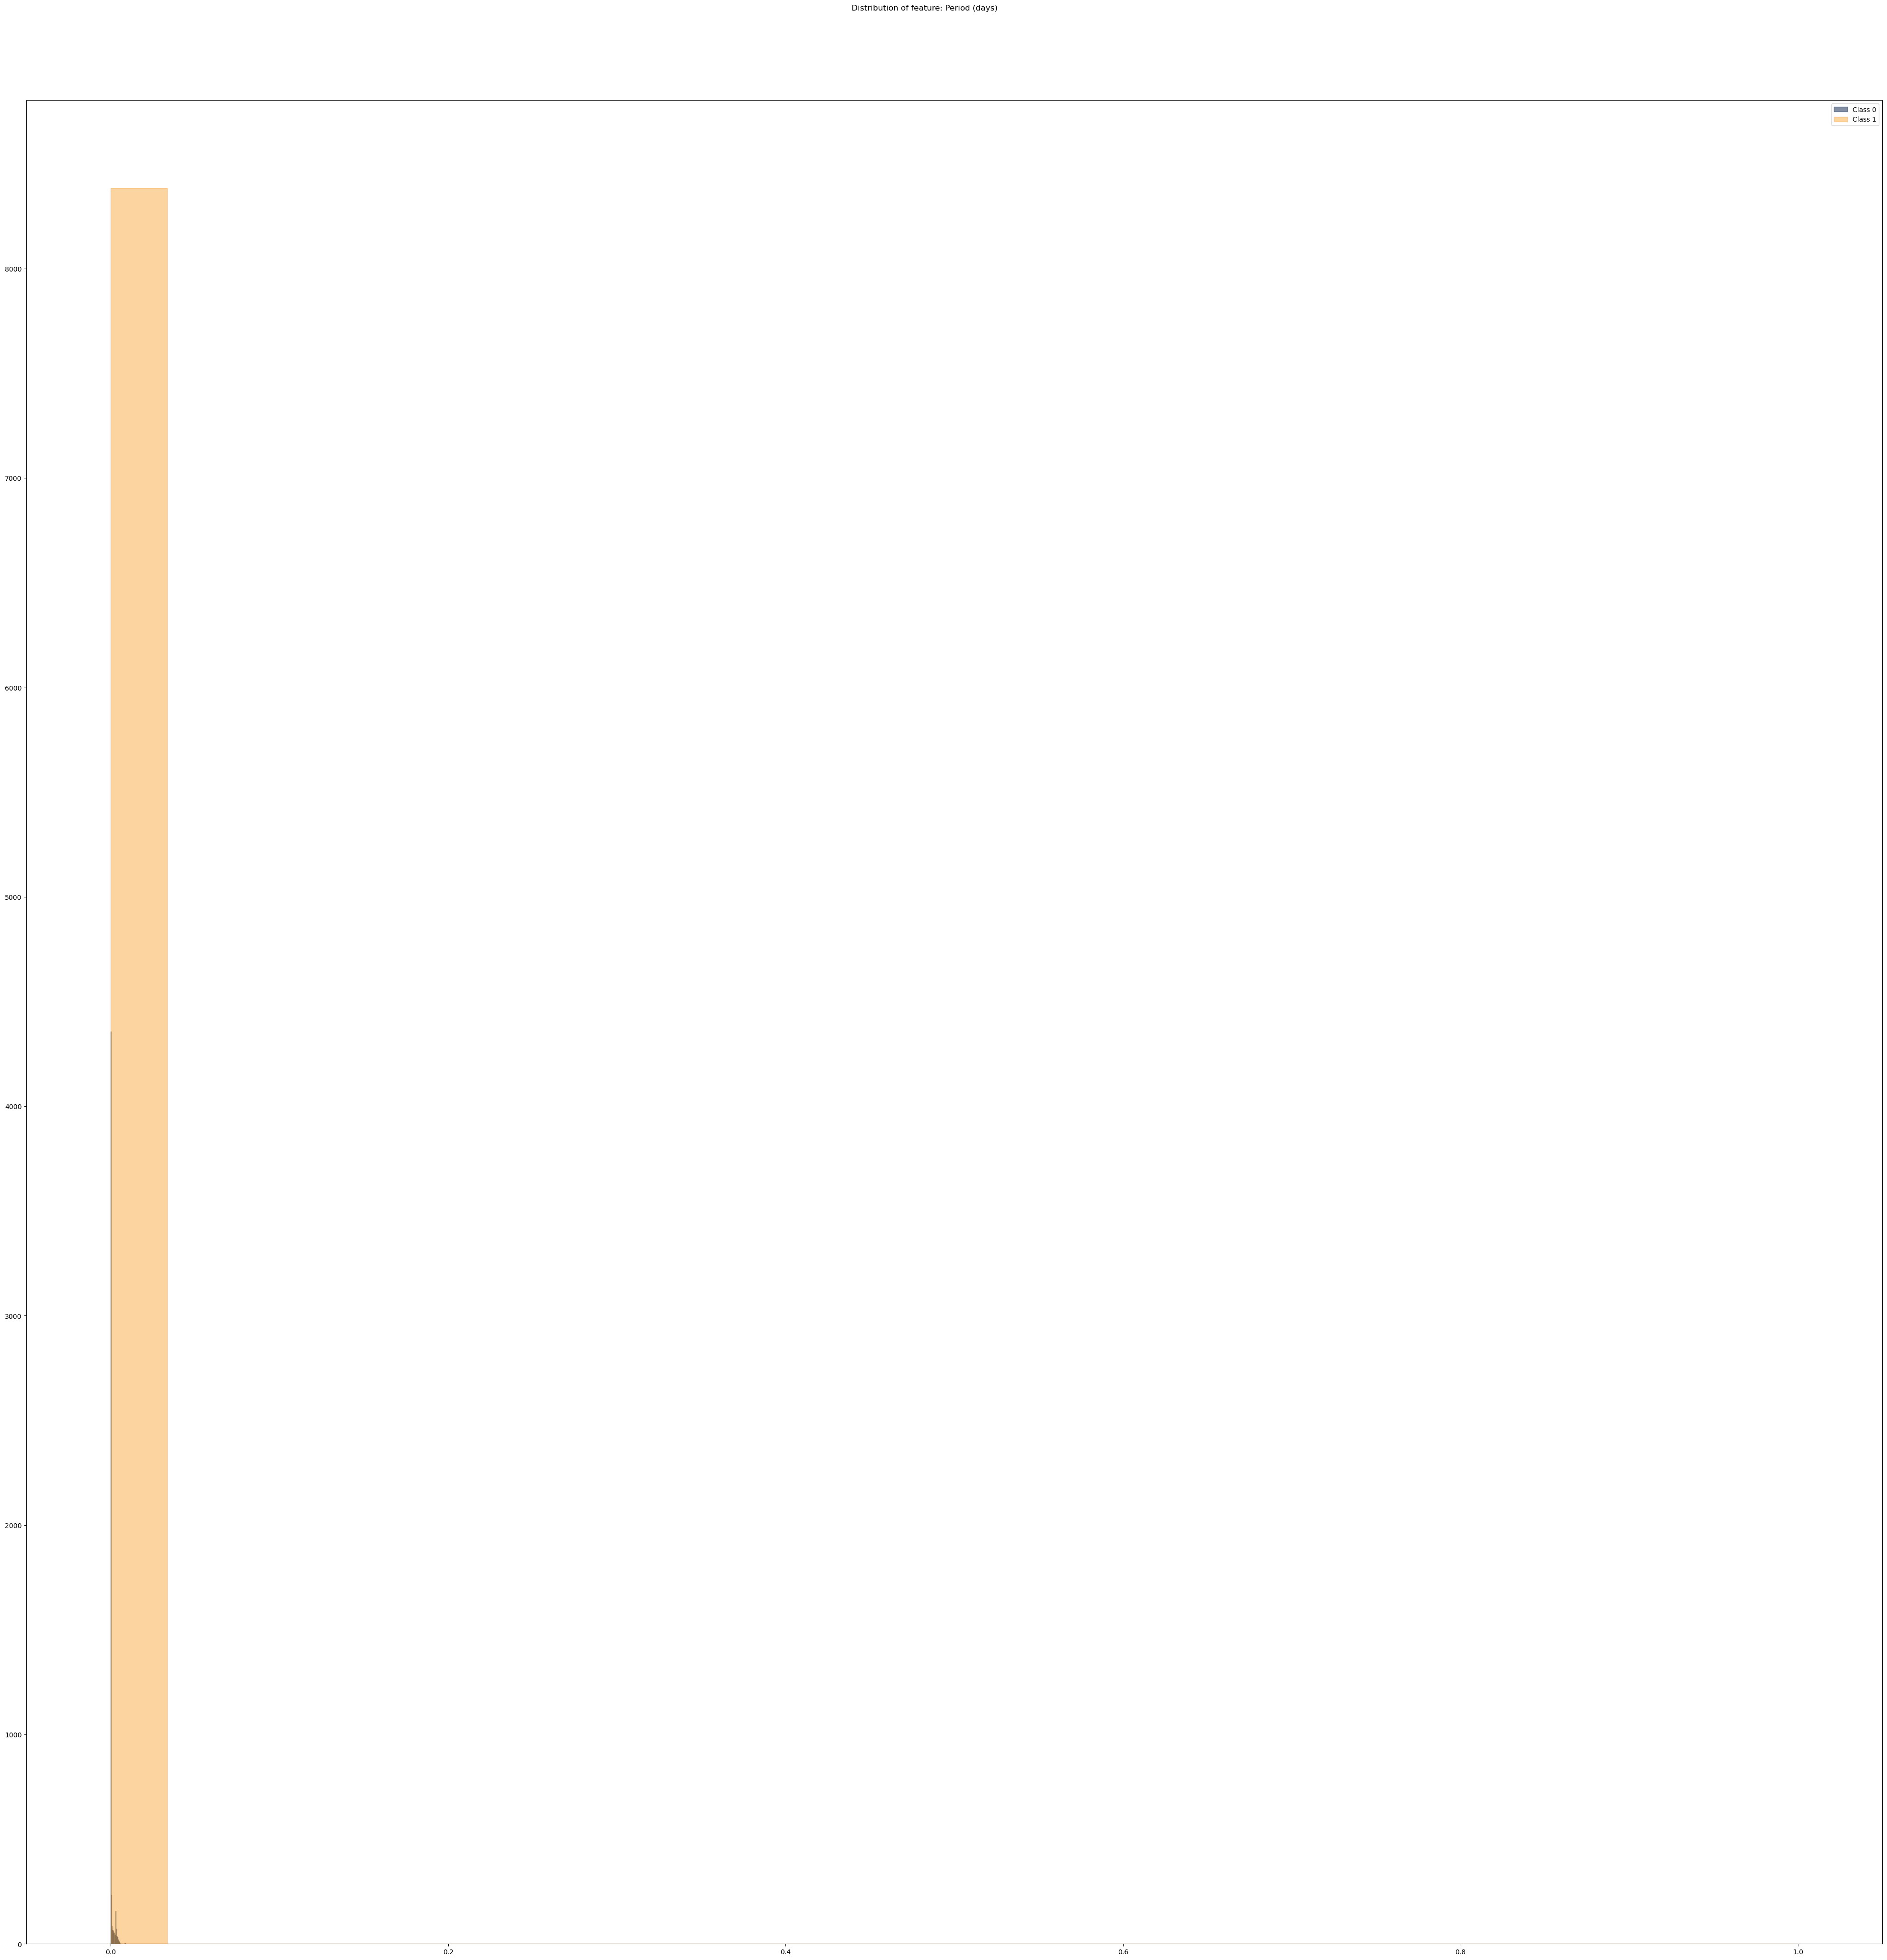

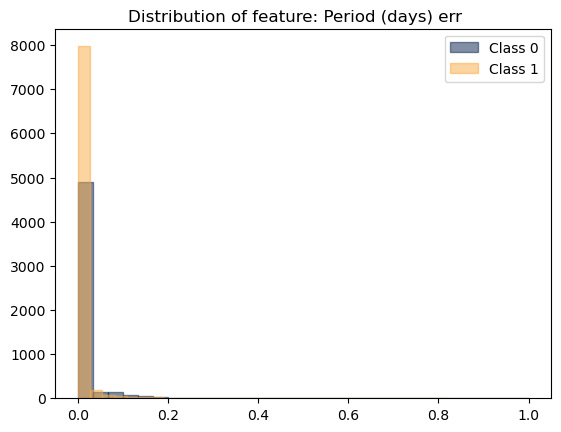

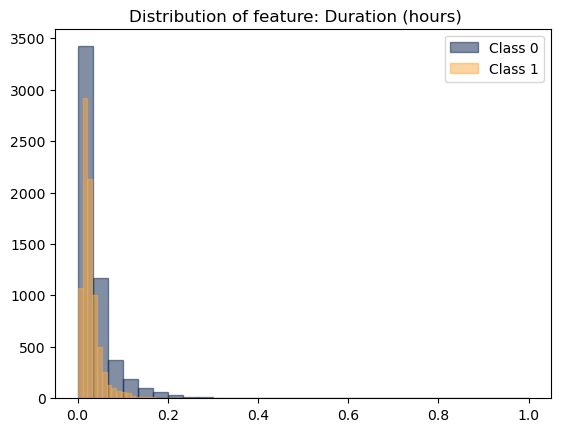

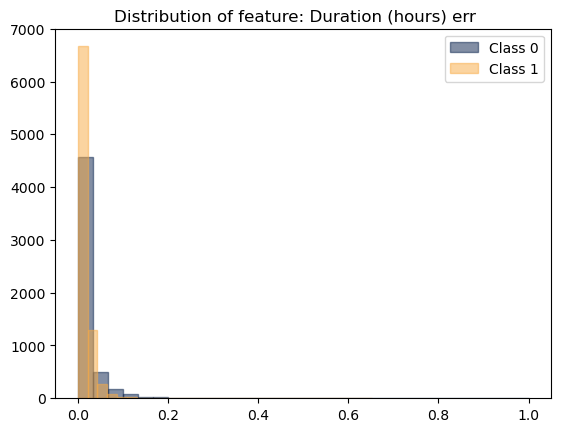

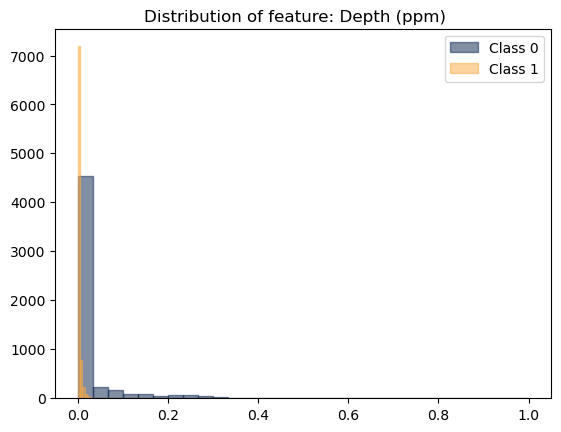

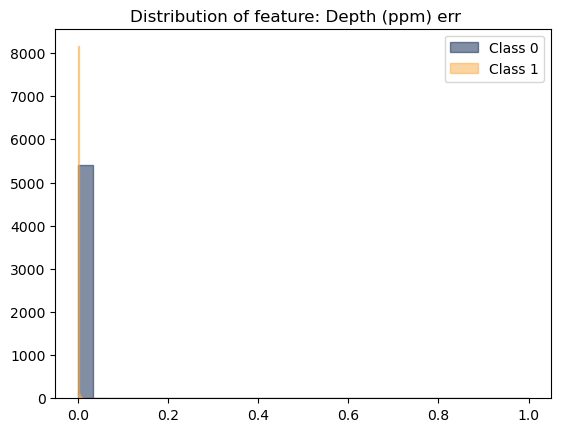

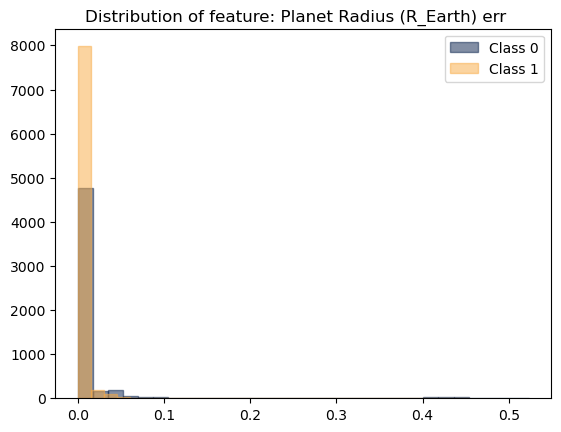

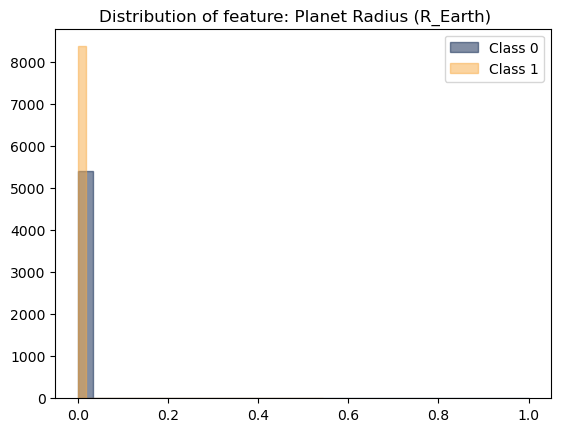

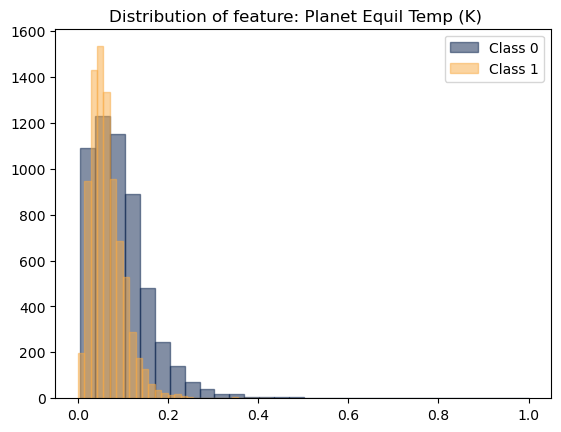

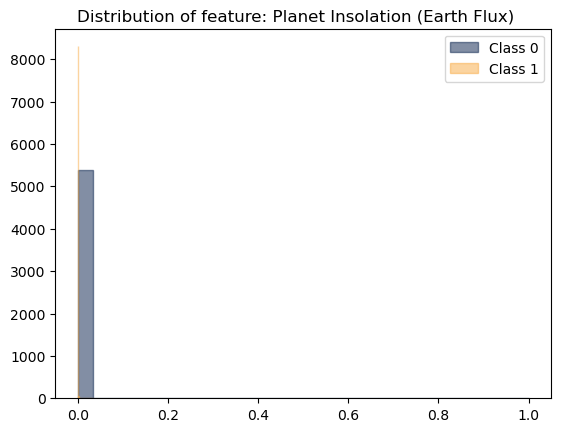

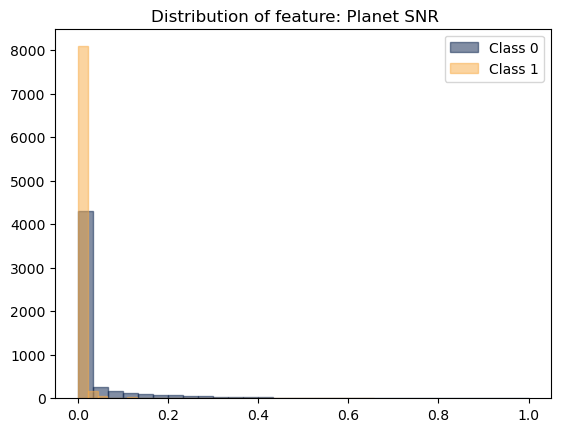

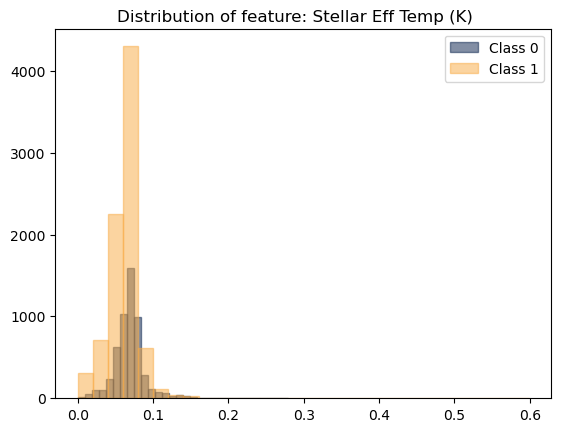

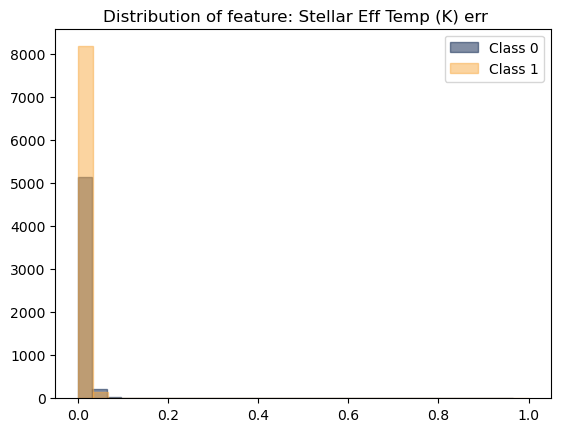

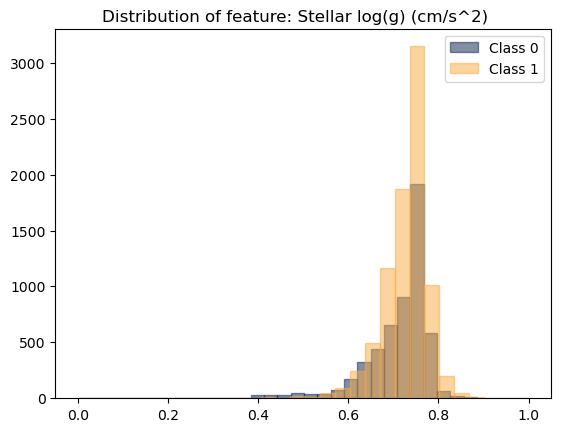

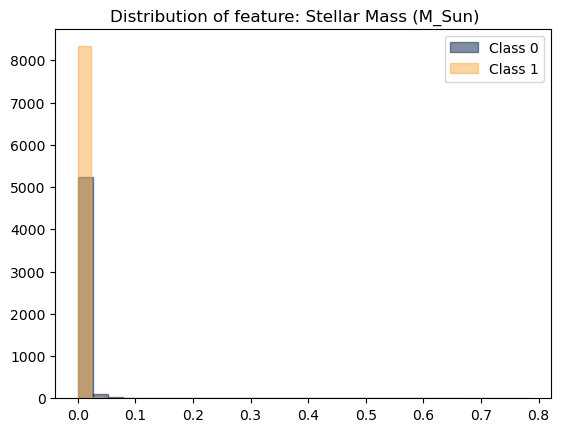

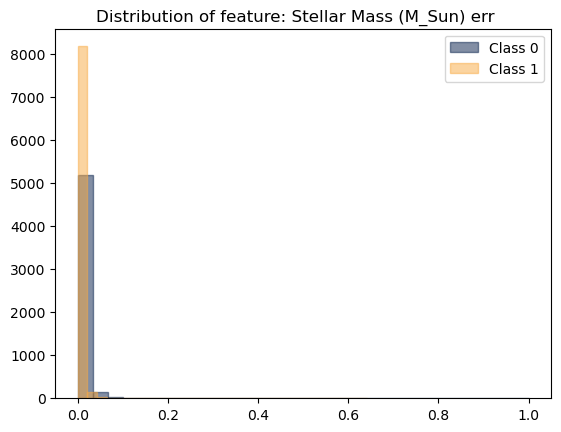

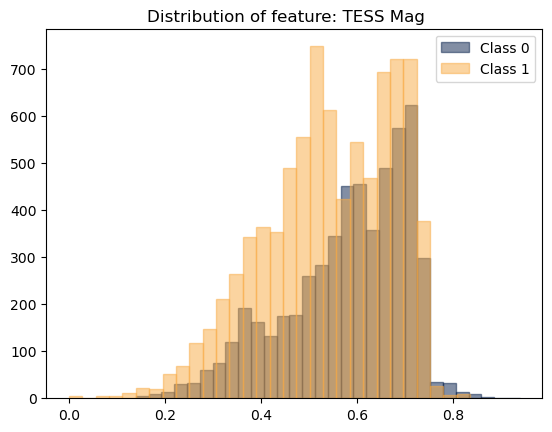

In [18]:
print('Plot After the scaling and KNNImputer')
plot_top_7_difference(X_train=X_train)
plot_hist_feature_distributions(X_train=X_train)
X_train_0, X_train_1 = compute_train_0_1(X_train=X_train, y_train=y_train)
plot_hist_feature_distributions(X_train=X_train_0)
plot_hist_feature_distributions(X_train=X_train_1)
plot_hist_feature_distributions_0_1(X_train_0=X_train_0, X_train_1=X_train_1)

# Feature Selection

Feature selection is a technique that associates a score with each feature and, based on a threshold T, thresholding is carried out so as to leave only the most important features. This technique is used to reduce overfitting and computational times.

It is done through the use of a Random Forest which provides us with the importance of the features.

In [19]:
N_JOBS = -1 # All CPU
feature_importances_ = compute_feature_importance(X_train=X_train, y_train=y_train, n_jobs=N_JOBS)
print_feature_importance(X_train=X_train, feature_importances_=feature_importances_)

1: Planet Radius (R_Earth)-------> 0.14312018536841853
2: Stellar Eff Temp (K) err------> 0.08774580014826683
3: Depth (ppm)-------------------> 0.06778241081998648
4: Stellar Mass (M_Sun) err------> 0.06176079132679567
5: Period (days)-----------------> 0.061177212083504295
6: Duration (hours)--------------> 0.06077712848394681
7: Duration (hours) err----------> 0.05848899643338768
8: Planet SNR--------------------> 0.05835862401804835
9: Period (days) err-------------> 0.05189535151943681
10:Planet Insolation (Earth Flux)> 0.05174477658357948
11:Planet Equil Temp (K)---------> 0.05169781970482325
12:Planet Radius (R_Earth) err---> 0.04905432880552903
13:TESS Mag----------------------> 0.04728962531511673
14:Depth (ppm) err---------------> 0.038190048725123354
15:Stellar Mass (M_Sun)----------> 0.037269293072848986
16:Stellar Eff Temp (K)----------> 0.03697859527056661
17:Stellar log(g) (cm/s^2)-------> 0.03666901232062111


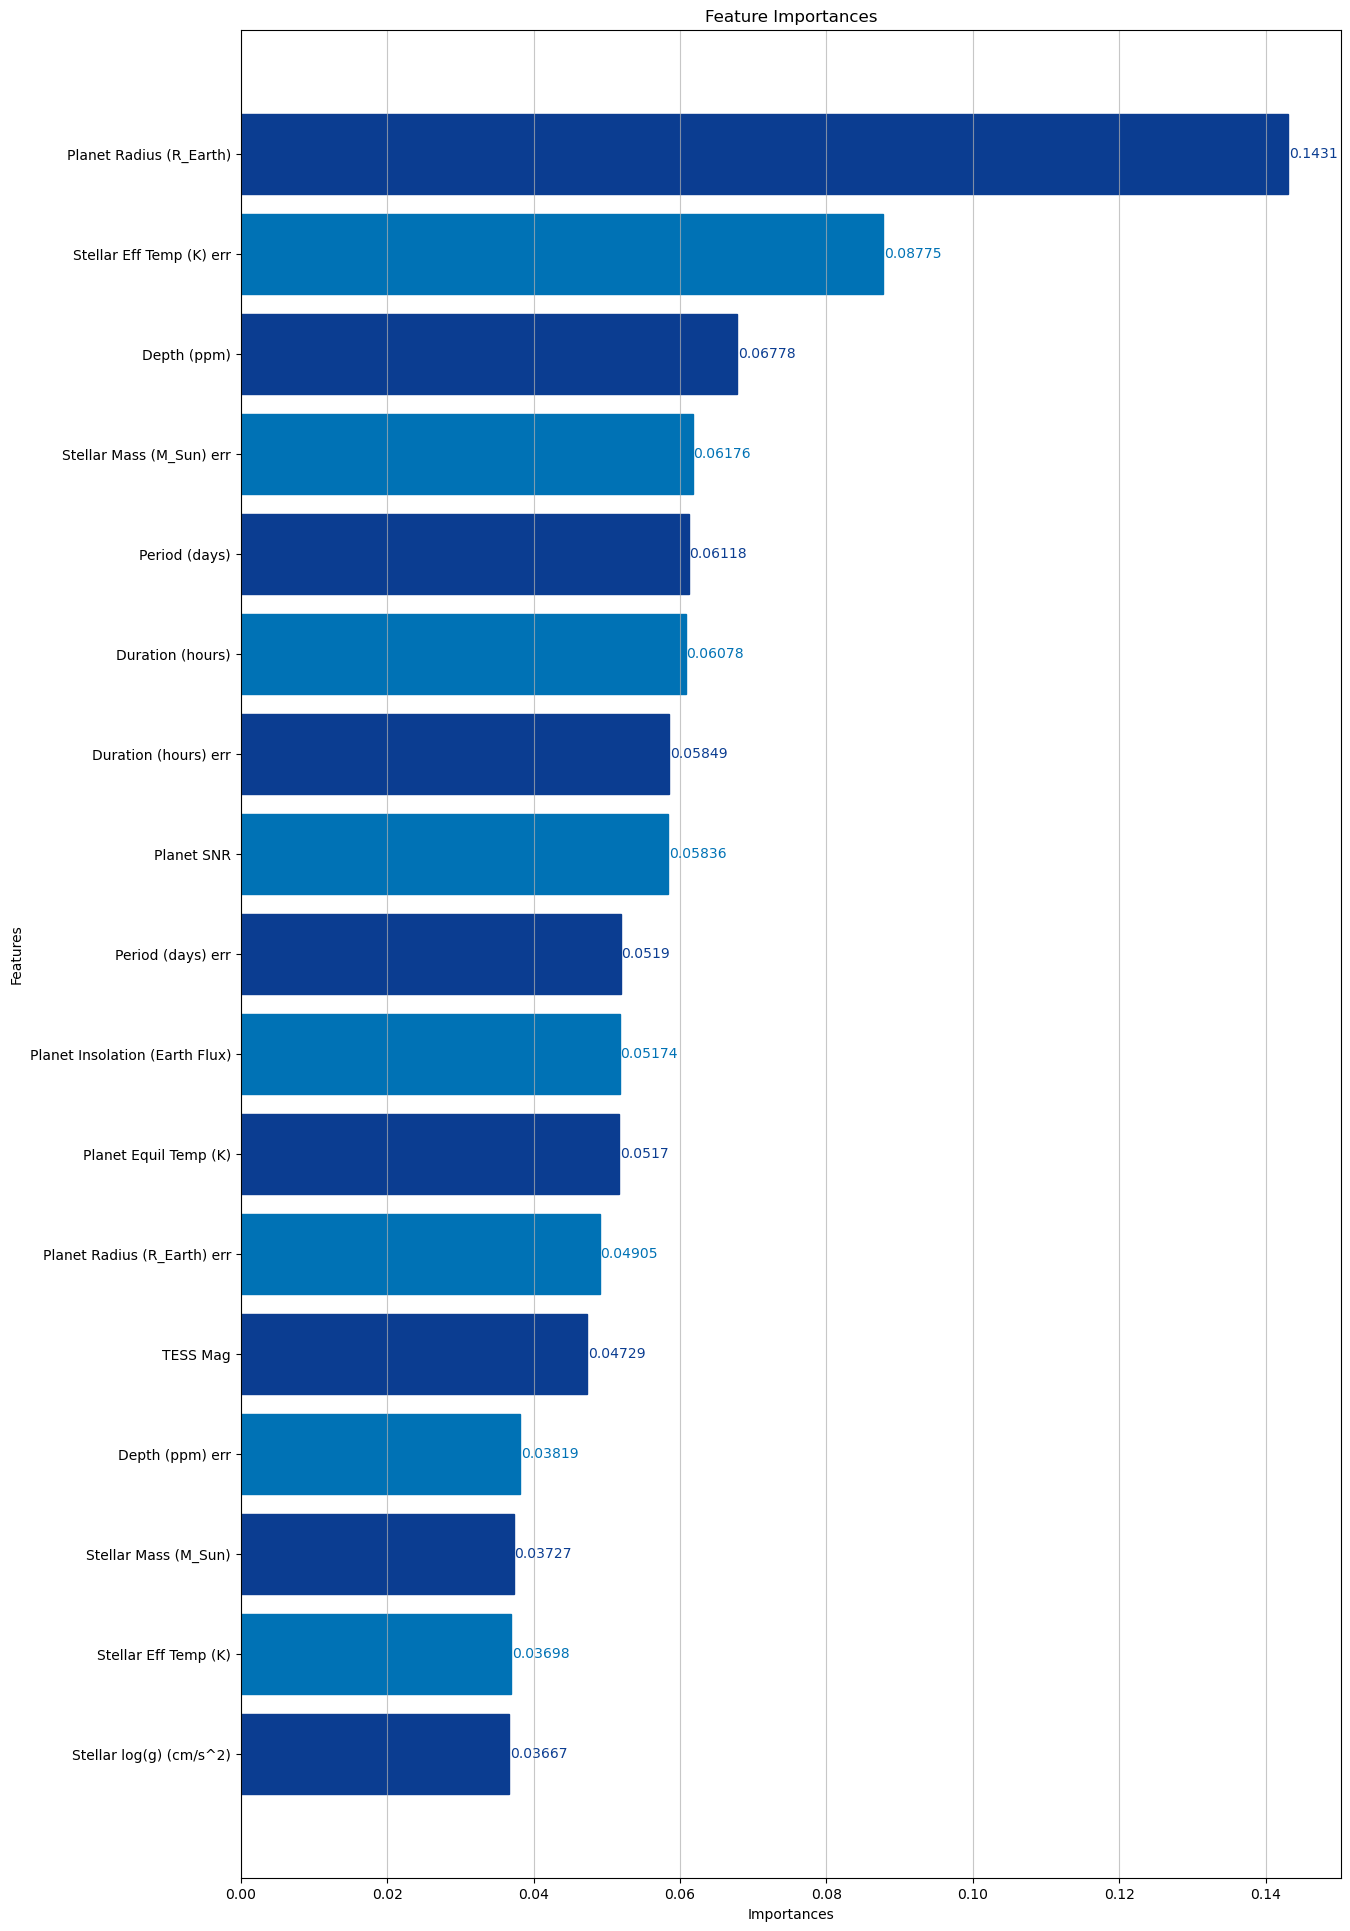

In [20]:
plot_feature_importances(X_train=X_train, feature_importances=feature_importances_)

In [21]:
PERCENTAGE = None # Drop features with importance = 0
X_train, columns_to_drop = feature_selection_rfc(X_train=X_train, feature_importances=feature_importances_,
                                                 percentage=PERCENTAGE)
print('Columns to drop:', columns_to_drop)
print('Shape of X_train data: ', X_train.shape)

Threshold computed:  0
Columns to drop: Index([], dtype='object')
Shape of X_train data:  (13798, 17)


# Dataset balancing

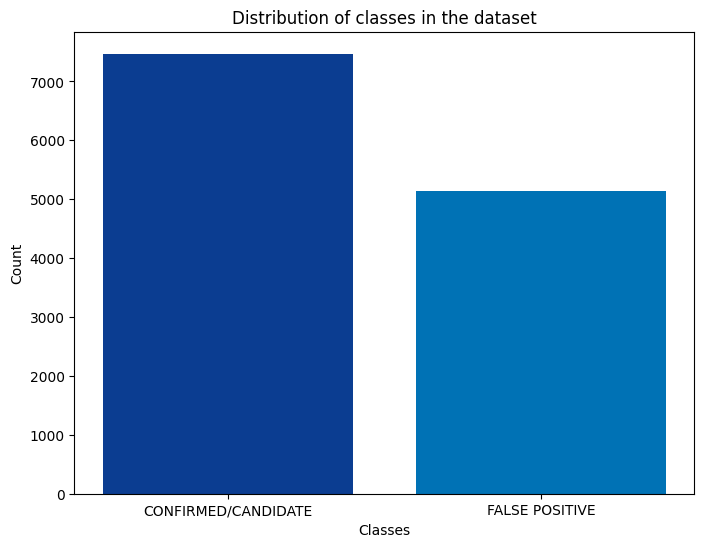

In [17]:
class_count_1, class_count_0 = plot_class_distribution(y_train=y_train)

In [18]:
print('Observations labeled 1:', class_count_1)
print('Observations labeled 0:', class_count_0)

Observations labeled 1: 7470.0
Observations labeled 0: 5144.0


In [19]:
# Save processed data
X_train.to_csv('../data/processed_data/X_kepler_tess_without_nan.csv')
y_train.to_csv('../data/processed_data/y_kepler_tess_without_nan.csv')

In [24]:
# Save processed data
X_train.to_csv('../data/processed_data/X_kepler_tess_mms.csv')
y_train.to_csv('../data/processed_data/y_kepler_tess_mms.csv')

In [85]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=42)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)

In [86]:
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)

Shape of X_train data:  (10288, 17)
Shape of y_train data:  (10288,)


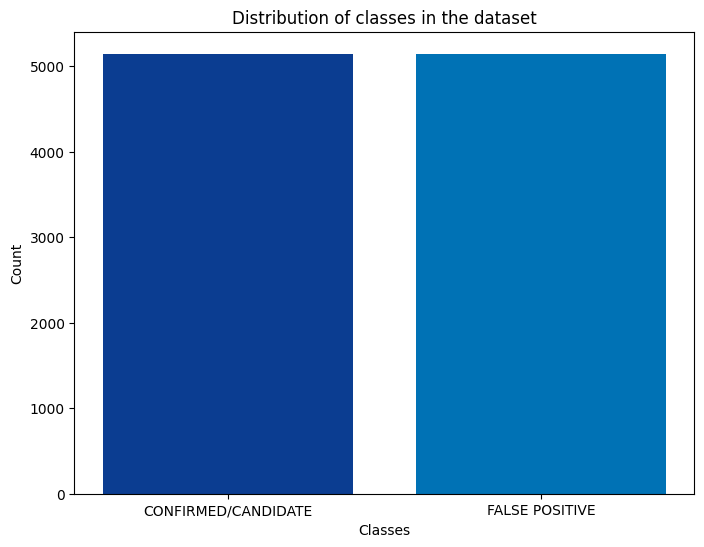

In [87]:
class_count_1, class_count_0 = plot_class_distribution(y_train=y_train)

In [88]:
print('Observations labeled 1:', class_count_1)
print('Observations labeled 0:', class_count_0)

Observations labeled 1: 5144.0
Observations labeled 0: 5144.0


# Class weighting

The error of the minority class weighs differently

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create class weight dictionary
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Train Test Split

In [89]:
TESTSET_SIZE = 0.2
RANDOM_STATE = 42

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=TESTSET_SIZE, 
                                                    random_state=RANDOM_STATE, shuffle=True, stratify=None)

# Checking class distributions after the split

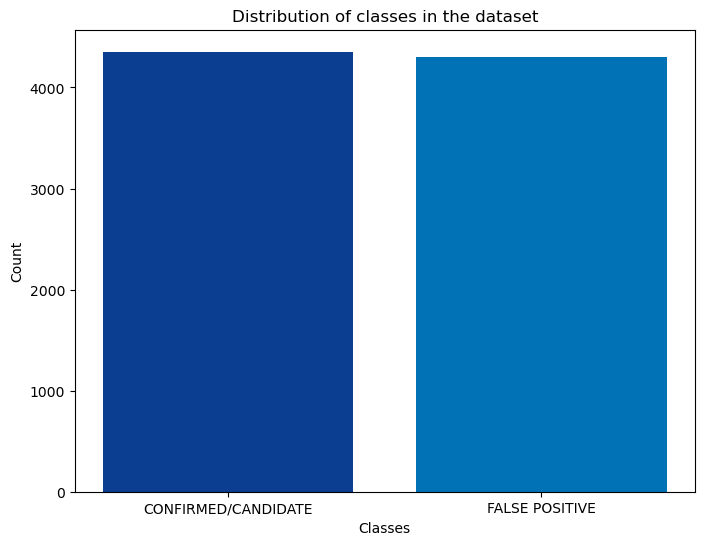

In [25]:
_, _ = plot_class_distribution(y_train=y_train)

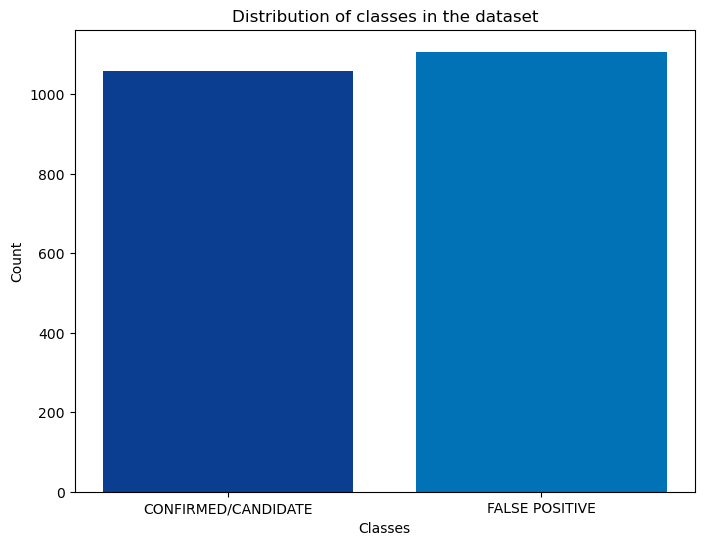

In [26]:
_, _ = plot_class_distribution(y_train=y_test)

In [36]:
x = X_train.copy()
y = y_train.copy()
X_train = pd.concat([X_train, x])
y_train = pd.concat([y_train, y])

In [87]:
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)
print('Shape of X_test data: ', X_test.shape)
print('Shape of y_test data: ', y_test.shape)

Shape of X_train data:  (11038, 17)
Shape of y_train data:  (11038,)
Shape of X_test data:  (2760, 17)
Shape of y_test data:  (2760,)


# Grid Searh

A common method that determines optimal parameters by evaluating metrics
of the model

In [30]:
best_params, best_score, best_estimator = grid_search_param_optimization(X_train=X_train,
                                                                        y_train=y_train, n_jobs=N_JOBS)
print('Best params:', best_params)
print('Best score:', best_score)
print('Best estimator:', best_estimator)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.6s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.6s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.6s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.7s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=

In [90]:
# Best params: {'max_depth': None, 'max_features': 2, 'min_samples_split': 5, 'n_estimators': 300}
# Best score: 0.8366794535548443
# Best estimator: RandomForestClassifier(max_features=2, min_samples_split=5, n_estimators=300,
#                        n_jobs=-1)

# Best params: {'max_depth': None, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 500}
# Best score: 0.8399171279788288
# Best estimator: RandomForestClassifier(max_features=3, n_estimators=500, n_jobs=-1)

best_params = {}
best_params['n_estimators'] = 500
best_params['max_features'] = 3
best_params['max_depth'] = None
best_params['min_samples_split'] = 2

# Random Forest Classifier

A random forest classifier.

A random forest is a metaestimator that fits a set of decision tree classifiers on various subsamples of the dataset and uses averaging to improve predictive accuracy and control overfitting.

In [91]:
# Extracting best hyperparameters
N_ESTIMATORS = best_params['n_estimators'] # The number of trees in the forest
MAX_FEATURE = best_params['max_features'] # The number of features to consider when looking for the best split
MAX_DEPTH = best_params['max_depth'] # The maximum depth of the tree
MIN_SAMPLES_SPLIT = best_params['min_samples_split'] # Minimum number of samples required to split a node into terno
CRITERION = 'entropy' # The function to measure the quality of a split
N_JOBS = -1
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=N_ESTIMATORS, criterion=CRITERION, 
                               max_depth=MAX_DEPTH, max_features=MAX_FEATURE,
                               min_samples_split=MIN_SAMPLES_SPLIT, random_state=RANDOM_STATE,
                               n_jobs=N_JOBS)
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=3, n_estimators=500,
                       n_jobs=-1, random_state=42)

$$
\text{Accuracy}: \frac{\text{true positives + true negatives}}{\text{true positives + true negatives + false positives + false negatives}}
$$ 


$$
\text{F-score}: 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

$$
\text{Precision}: \frac{\text{true positives}}{\text{true positives + false positives}}
$$


$$
\text{Recall}: \frac{\text{true positives}}{\text{true positives + false negatives}}
$$

Accuracy: 0.8309037900874635
F1-score: 0.830078125
Precision: 0.819672131147541
Recall: 0.8407517309594461
cm:  [[860 187]
 [161 850]]


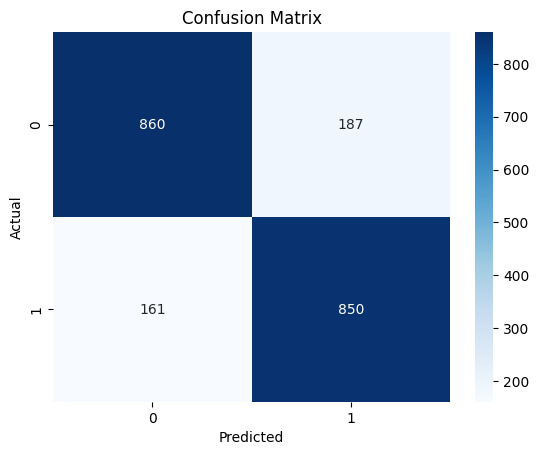

"\nTCOL = 2400\nTROW = 1\nN_ESTIMATORS = 500\nMAX_FEATURE = 3\nMAX_DEPTH = None\nMIN_SAMPLES_SPLIT = 2\nCRITERION = 'entropy'\nAccuracy: 83,18%\nF1-score: 86,49%\nPrecision: 83,29%\nRecall: 89,95%\ncm: [[810, 298][166, 1486]]\n"

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

predictions = model.predict(X_test)

# Determine performance metrics
cm = confusion_matrix(y_test, predictions)
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1-score:', f1_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))
print("cm: ", cm)

# Visualizza la matrice di confusione
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

"""
TCOL = 5000
TROW = 3
N_ESTIMATORS = 300
MAX_FEATURE = 5
MAX_DEPTH = None
MIN_SAMPLES_SPLIT = 7
CRITERION = 'entropy'
Accuracy: 83,30%
F1-score: 86,57%
Precision: 83,57%
Recall: 89,80%
cm: [[839, 301][174, 1532]]
"""

"""
TCOL = 2400
TROW = 1
N_ESTIMATORS = 500
MAX_FEATURE = 3
MAX_DEPTH = None
MIN_SAMPLES_SPLIT = 2
CRITERION = 'entropy'
Accuracy: 83,18%
F1-score: 86,49%
Precision: 83,29%
Recall: 89,95%
cm: [[810, 298][166, 1486]]
"""

In [34]:
print_feature_importance(X_train=X_train, feature_importances_=model.feature_importances_)

1: Planet Radius (R_Earth)-------> 0.14010867514998143
2: Stellar Eff Temp (K) err------> 0.09591333856813898
3: Depth (ppm)-------------------> 0.06566594479257072
4: Period (days)-----------------> 0.06500258166416335
5: Duration (hours) err----------> 0.06170896889666552
6: Duration (hours)--------------> 0.06167277831723654
7: Stellar Mass (M_Sun) err------> 0.06073312406609833
8: Planet SNR--------------------> 0.05677846749482979
9: Period (days) err-------------> 0.05053936048971108
10:Planet Radius (R_Earth) err---> 0.04884645275075321
11:Planet Equil Temp (K)---------> 0.04873253192623071
12:TESS Mag----------------------> 0.04778922136388904
13:Planet Insolation (Earth Flux)> 0.047502253879978314
14:Stellar Eff Temp (K)----------> 0.03814160077954901
15:Depth (ppm) err---------------> 0.03784934060907803
16:Stellar Mass (M_Sun)----------> 0.03668200890911075
17:Stellar log(g) (cm/s^2)-------> 0.03633335034201518


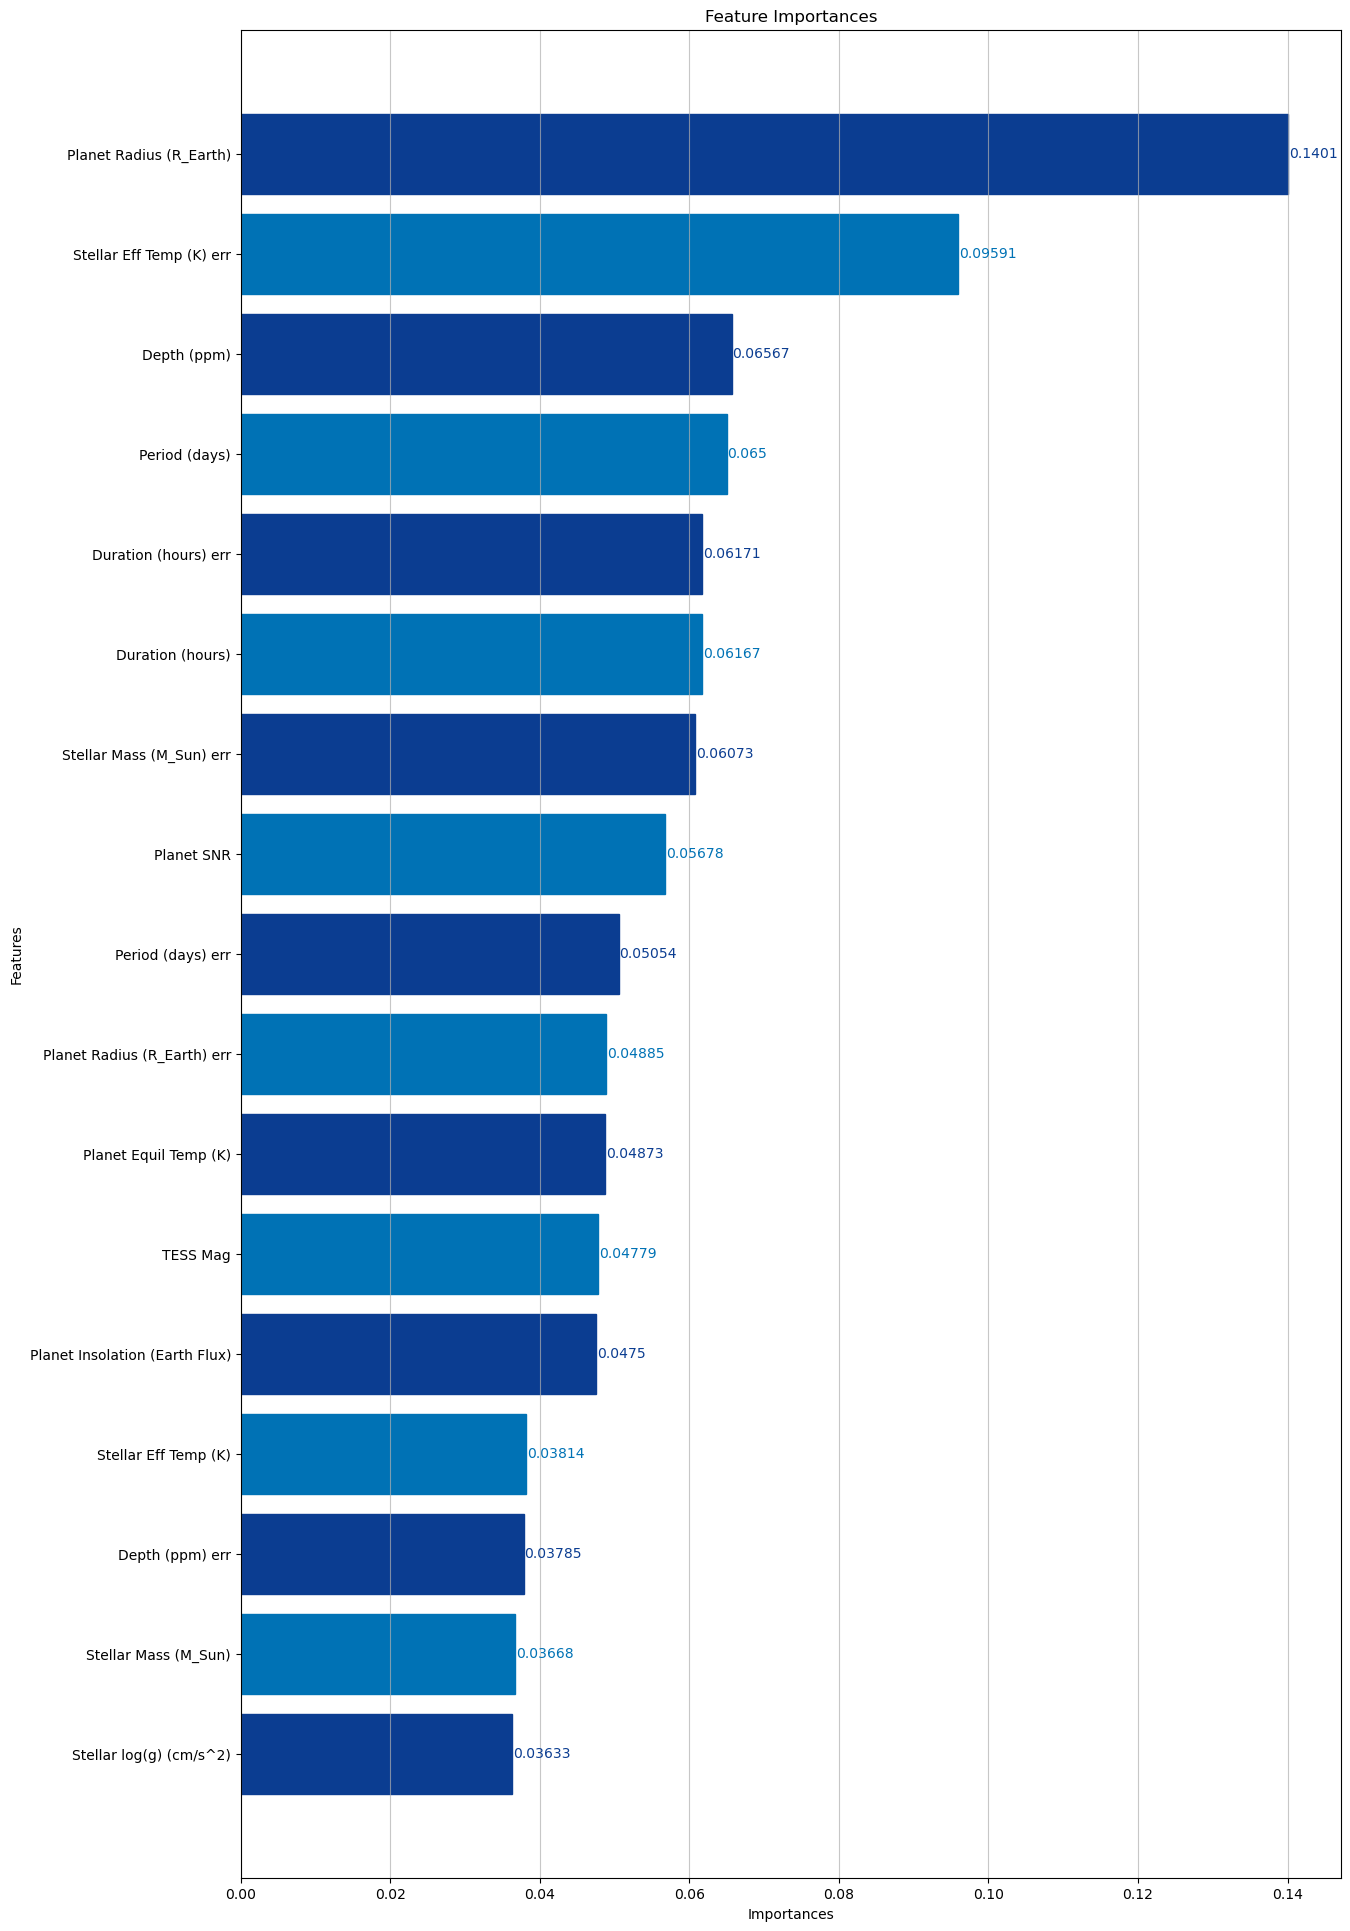

In [35]:
plot_feature_importances(X_train=X_train, feature_importances=model.feature_importances_)

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Decision Tree
dt_params = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10, 11]}
dt_classifier = DecisionTreeClassifier()
dt_grid_search = GridSearchCV(dt_classifier, dt_params, cv=5, n_jobs=N_JOBS, verbose=2)
dt_grid_search.fit(X_train, y_train)

# K-Nearest Neighbors
knn_params = {'n_neighbors': [3, 5, 7, 11, 15, 33]}
knn_classifier = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn_classifier, knn_params, cv=5, n_jobs=N_JOBS, verbose=2)
knn_grid_search.fit(X_train, y_train)

# Gradient Boosting
gb_params = {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2, 0.001, 0.4]}
gb_classifier = GradientBoostingClassifier()
gb_grid_search = GridSearchCV(gb_classifier, gb_params, cv=5, n_jobs=N_JOBS, verbose=2)
gb_grid_search.fit(X_train, y_train)

# Print the best parameters for each classifier
print("Best parameters for Decision Tree:", dt_grid_search.best_params_)
print("Best parameters for K-Nearest Neighbors:", knn_grid_search.best_params_)
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)

# Make predictions on the test set for each classifier
dt_predictions = dt_grid_search.predict(X_test)
knn_predictions = knn_grid_search.predict(X_test)
gb_predictions = gb_grid_search.predict(X_test)

# Evaluate accuracy for each classifier
dt_accuracy = accuracy_score(y_test, dt_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)
gb_accuracy = accuracy_score(y_test, gb_predictions)

print("Accuracy for Decision Tree:", dt_accuracy)
print("Accuracy for K-Nearest Neighbors:", knn_accuracy)
print("Accuracy for Gradient Boosting:", gb_accuracy)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.3s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.3s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.4s
[CV] END ...............max_depth=None, min_samples_split=10; total time=   0.4s
[CV] END ...............max_depth=None, min_samples_split=10; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.4s
[CV] END ...............max_depth=None, min_samples_split=11; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.4s
[CV] END ................max_depth=None, min_sam

In [37]:
# Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 11}
# Best parameters for K-Nearest Neighbors: {'n_neighbors': 15}
# Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'n_estimators': 500}
# Accuracy for Decision Tree: 0.7940969782150387
# Accuracy for K-Nearest Neighbors: 0.8000702740688685
# Accuracy for Gradient Boosting: 0.8348559381588194

# Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 5}
# Best parameters for K-Nearest Neighbors: {'n_neighbors': 11}
# Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'n_estimators': 200}
# Accuracy for Decision Tree: 0.8109452736318408
# Accuracy for K-Nearest Neighbors: 0.7910447761194029
# Accuracy for Gradient Boosting: 0.8338308457711443

# Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 10}
# Best parameters for K-Nearest Neighbors: {'n_neighbors': 15}
# Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'n_estimators': 500}
# Accuracy for Decision Tree: 0.8014492753623188
# Accuracy for K-Nearest Neighbors: 0.8018115942028986
# Accuracy for Gradient Boosting: 0.8315217391304348

In [118]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(
    # hidden_layer_sizes=(100, 50),  # Numero di neuroni in ciascun strato nascosto
    activation='relu',             # Funzione di attivazione
    solver='adam',                 # Algoritmo di ottimizzazione
    alpha=0.0001,                   # Termine di regolarizzazione L2
    learning_rate='constant',      # Schema di aggiornamento del tasso di apprendimento
    learning_rate_init=0.001,       # Tasso di apprendimento iniziale
    max_iter=2000,                   # Numero massimo di iterazioni sull'intero dataset
    random_state=42,                 # Seme casuale per la riproducibilità
    verbose=True
)

mlp.fit(X_train, y_train)

Iteration 1, loss = 0.65997189
Iteration 2, loss = 0.63766683
Iteration 3, loss = 0.61106108
Iteration 4, loss = 0.58387056
Iteration 5, loss = 0.56050155
Iteration 6, loss = 0.54304449
Iteration 7, loss = 0.53118047
Iteration 8, loss = 0.52348431
Iteration 9, loss = 0.51734292
Iteration 10, loss = 0.51361366
Iteration 11, loss = 0.50946995
Iteration 12, loss = 0.50763942
Iteration 13, loss = 0.50535774
Iteration 14, loss = 0.50344985
Iteration 15, loss = 0.50167854
Iteration 16, loss = 0.49987192
Iteration 17, loss = 0.49946195
Iteration 18, loss = 0.49721532
Iteration 19, loss = 0.49587880
Iteration 20, loss = 0.49414716
Iteration 21, loss = 0.49298276
Iteration 22, loss = 0.49125553
Iteration 23, loss = 0.49024591
Iteration 24, loss = 0.48905357
Iteration 25, loss = 0.48711564
Iteration 26, loss = 0.48592329
Iteration 27, loss = 0.48502128
Iteration 28, loss = 0.48342264
Iteration 29, loss = 0.48223326
Iteration 30, loss = 0.48087858
Iteration 31, loss = 0.47942270
Iteration 32, los

MLPClassifier(max_iter=2000, random_state=42, verbose=True)

In [119]:
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 81.78%
